In [5]:
import os, sys
import rasterio
from rasterio.mask import mask
import numpy as np
from matplotlib import pyplot as plt
import glob
from xml.dom import minidom
import fiona
from shapely.geometry import mapping, shape
import scipy.misc as misc
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

In [6]:
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    return fig.colorbar(mappable, cax=cax)

# function to return collection dates from Planet MultiSpectral image metadata
def getDates_planet(xml_file):

    xmldoc = minidom.parse(xml_file)
    date_node = xmldoc.getElementsByTagName("eop:acquisitionDate")
    date_str = str(date_node[0].firstChild.nodeValue)
    acq_date_yyyymmdd = date_str.split('T')[0]        
    
    return acq_date_yyyymmdd

# function to return correction coefficients from Planet MultiSpectral image metadata
def getCorrCoefs_planet(xml_file):

    xmldoc = minidom.parse(xml_file)
    nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

    # XML parser refers to bands by numbers 1-4
    coeffs = {}
    for node in nodes:
        bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
        if bn in ['1', '2', '3', '4']:
            i = int(bn)
            value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
            coeffs[i] = float(value)
            
    return coeffs

# function to extract image patch
def getImagePatch_planet(imfile, poly):
    
    try:
        with rasterio.open(imfile, 'r') as src:
            arr,_ = mask(src, [poly], crop=True)

        if arr.sum() != 0.:
            return arr
        else:
            return 0
        
    except:
        return 0

# function return geometries as geoJSON
def getGeometries_planet(shpfile):
    
    with fiona.open(shpfile, "r") as shapefile:
        geoms = [feature["geometry"] for feature in shapefile]
        
    return geoms


def getMeansBand(arr, nbands):
    
    res=[]
    for i in range(nbands):
        res.append(arr[i,:,:].mean())
    
    return res

def getSTDband(arr, nbands):
    
    res=[]
    for i in range(nbands):
        res.append(arr[i,:,:].std())
    
    return res

def cor_ms(ms_temp, cf_arr):
    # extract the band means per patch
    ms_band1 = [b[0,:,:] for b in ms_temp]
    ms_band2 = [b[1,:,:] for b in ms_temp]
    ms_band3 = [b[2,:,:] for b in ms_temp]
    ms_band4 = [b[3,:,:] for b in ms_temp]
    
    # correct the ms images to TOA reflectance
    ms_band1_cor = [cf[0] * mn for cf,mn in zip(cf_arr, ms_band1)]
    ms_band2_cor = [cf[1] * mn for cf,mn in zip(cf_arr, ms_band2)]
    ms_band3_cor = [cf[2] * mn for cf,mn in zip(cf_arr, ms_band3)]
    ms_band4_cor = [cf[3] * mn for cf,mn in zip(cf_arr, ms_band4)]
    
    res = []
    for i in range(len(ms_band1_cor)):
        res.append(np.rollaxis(np.dstack((ms_band1_cor[i], ms_band2_cor[i], ms_band3_cor[i], ms_band4_cor[i])),2,0))
    
    return res
    
def meanIntensityOverGeometry_simple_Landsat(bandlist, poly):
    
    # SR scale factor
    sr_scale = 10000.
    
    # get the band patches. should be 4 of size 1xrowsxcols items, [blue, green, red, nir]
    band_patches = [getImagePatch_planet(im, poly) for im in bandlist]
    #band_temp = [np.ma.masked_equal(arr, -9999.)/sr_scale for arr in band_patches if type(arr) is np.ma.core.MaskedArray]
    band_temp = [np.ma.masked_equal(arr, -9999.)/sr_scale for arr in band_patches]
    #band_means = [getMeansBand(im,1) for im in band_temp]
    band_means = [im.mean() for im in band_temp]
    band_std = [im.std() for im in band_temp]
    
    res = {}
    res['sr_means'] = band_means
    res['numpixels'] = band_temp[0].count()
    res['sr_std'] = band_std
    
    #band_temp = [np.ma.masked_equal(arr, -9999.) for arr in band_temp]
    res['image'] = np.ma.array([b.squeeze() for b in band_temp])
    return res
    

# define function which process the planet images within a specified geometry
def meanIntensityOverGeometry_simple(im, xml, poly):
    
    # SR scale factor
    sr_scale = 10000.    
    
    #ms_patch = getImagePatch_planet(im, poly)
    sr_patch = getImagePatch_planet(im, poly) #/ sr_scale 
    
    coeffs = getCorrCoefs_planet(xml)
    date_s = getDates_planet(xml)
    
    #ms_patch_temp = [ms_patches[i] for i in xml_inds]
    #ms_temp = [np.ma.masked_equal(arr, 0.0) for arr in ms_patch_temp if type(arr) is np.ma.core.MaskedArray]
    #ms_cor = cor_ms(ms_temp, cf_arr) # correct the MS imagery to TOA reflectance
    #ms_means = [getMeansBand(arr,4) for arr in ms_cor]

    #sr_patch_temp = [sr_patches[i] for i in xml_inds]
    #sr_temp = [np.ma.masked_equal(arr, 0.0) for arr in sr_patch_temp if type(arr) is np.ma.core.MaskedArray]
    sr_temp = np.ma.masked_equal(sr_patch, 0.0) / sr_scale
    sr_means = getMeansBand(sr_temp,4)
    sr_stds = getSTDband(sr_temp, 4)
    
    
    
    # extract the band means per patch
    #ms_band1_mean = [b[0] for b in ms_means]
    #ms_band2_mean = [b[1] for b in ms_means]
    #ms_band3_mean = [b[2] for b in ms_means]
    #ms_band4_mean = [b[3] for b in ms_means]

    
    sr_band1_mean = sr_means[0] #/sr_scale 
    sr_band2_mean = sr_means[1] #/sr_scale 
    sr_band3_mean = sr_means[2] #/sr_scale 
    sr_band4_mean = sr_means[3] #/sr_scale
    
    sr_band1_std = sr_stds[0]
    sr_band2_std = sr_stds[1]
    sr_band3_std = sr_stds[2]
    sr_band4_std = sr_stds[3]
    
    # put the dates in a usable list corresponding to only overlapping images
    #date_arr = [dates[i] for i in xml_inds]

    res = {}
    #res['ms_means'] = [ms_band1_means, ms_band2_means, ms_band3_means, ms_band4_means]
    res['sr_means'] = [sr_band1_mean, sr_band2_mean, sr_band3_mean, sr_band4_mean]
    res['sr_std'] = [sr_band1_std, sr_band2_std, sr_band3_std, sr_band4_std]
    res['dates'] = date_s
    res['numpixels'] = sr_temp[0,:,:].count()
    res['image'] = sr_temp
#     res['ms_std'] = [ms_band1_std_cor, ms_band2_std_cor, ms_band3_std_cor, ms_band4_std_cor]
#     res['sr_std'] = [sr_band1_std, sr_band2_std, sr_band3_std, sr_band4_std]
    return res


def returnSamples(pl_imArr, oli_imArr, method='direct'):
    '''this function returns the planet samples within a landsat pixel.
        The list of methods is to account for how the landsat pixel is sampled for each set of planet pixels.
        Currently, 'direct' is the only one and assigns the same landsat pixel for each planet pixel in the set'''
    
    # get the rows and columns of the landsat data
    oli_rows, oli_cols = oli_imArr.shape
    
    # get the rows and columns of the planet data
    planet_rows, planet_cols = pl_imArr.shape
    
    # get the row/column factors for how many planet pixels will fit in a landsat pixel
    row_fact = int(np.floor(planet_rows/oli_rows))
    col_fact = int(np.floor(planet_cols/oli_cols))
    
    # it is not necessarily an even number given the spatial extraction, so add in the modulus
    row_mod = planet_rows%oli_rows
    col_mod = planet_cols%oli_cols
    
    # get the ranges of pixels to grab from planet
    row_sets = np.arange(0,planet_rows, row_fact) + row_mod
    col_sets = np.arange(0, planet_cols, col_fact) + col_mod
    
    
    
    # sample via landsat
    samples = []
    for r in range(oli_rows-1):
        for c in range(oli_cols-1):
            
            # get the landsat pixel
            oli_pix_val = oli_imArr[r,c]
            
            # get the pixels from planet if the pixel is not 0 or -9999
            if oli_pix_val is not np.ma.masked: # set the condition later
                pl_row_start = row_sets[r]
                pl_row_end = row_sets[r+1]
                pl_col_start = col_sets[c]
                pl_col_end = col_sets[c+1]
                pl_pix = pl_imArr[pl_row_start:pl_row_end, pl_col_start:pl_col_end].ravel()
                
                oli_pix = np.ones(pl_pix.shape)*oli_pix_val
                samples.append(np.vstack((oli_pix, pl_pix)))
    
    return samples

def returnSamplesMeanStd(pl_imArr, oli_imArr, method='direct'):
    '''this function returns the planet samples within a landsat pixel.
        The list of methods is to account for how the landsat pixel is sampled for each set of planet pixels.
        Currently, 'direct' is the only one and assigns the same landsat pixel for each planet pixel in the set'''
    
    # get the rows and columns of the landsat data
    oli_rows, oli_cols = oli_imArr.shape
    
    # get the rows and columns of the planet data
    planet_rows, planet_cols = pl_imArr.shape
    
    # get the row/column factors for how many planet pixels will fit in a landsat pixel
    row_fact = int(np.floor(planet_rows/oli_rows))
    col_fact = int(np.floor(planet_cols/oli_cols))
    
    # it is not necessarily an even number given the spatial extraction, so add in the modulus
    row_mod = planet_rows%oli_rows
    col_mod = planet_cols%oli_cols
    
    # get the ranges of pixels to grab from planet
    row_sets = np.arange(0,planet_rows, row_fact) + row_mod
    col_sets = np.arange(0, planet_cols, col_fact) + col_mod
    
    # sample via landsat
    samples = []
    for r in range(oli_rows-1):
        for c in range(oli_cols-1):
            
            # get the landsat pixel
            oli_pix_val = oli_imArr[r,c]
            
            # get the pixels from planet if the pixel is not 0 or -9999
            if oli_pix_val is not np.ma.masked: # set the condition later
                pl_row_start = row_sets[r]
                pl_row_end = row_sets[r+1]
                pl_col_start = col_sets[c]
                pl_col_end = col_sets[c+1]
                pl_pix = pl_imArr[pl_row_start:pl_row_end, pl_col_start:pl_col_end].ravel()
                pl_pix_mean = np.mean(pl_pix)
                pl_pix_std = np.std(pl_pix)
                pl_pix_max = np.max(pl_pix)
                pl_pix_min = np.min(pl_pix)
                
                
                samples.append(np.array([[oli_pix_val], [pl_pix_mean], [pl_pix_std], [pl_pix_max - pl_pix_min]]))
    
    return samples

def returnSamplesMeanStd_ndvi(pl_imArr_red, pl_imArr_nir, oli_imArr_red, oli_imArr_nir, method='direct'):
    '''this function returns the planet samples within a landsat pixel.
        The list of methods is to account for how the landsat pixel is sampled for each set of planet pixels.
        Currently, 'direct' is the only one and assigns the same landsat pixel for each planet pixel in the set'''
    
    # get the rows and columns of the landsat data
    oli_rows, oli_cols = oli_imArr_red.shape
    
    # get the rows and columns of the planet data
    planet_rows, planet_cols = pl_imArr_red.shape
    
    # get the row/column factors for how many planet pixels will fit in a landsat pixel
    row_fact = int(np.floor(planet_rows/oli_rows))
    col_fact = int(np.floor(planet_cols/oli_cols))
    
    # it is not necessarily an even number given the spatial extraction, so add in the modulus
    row_mod = planet_rows%oli_rows
    col_mod = planet_cols%oli_cols
    
    # get the ranges of pixels to grab from planet
    row_sets = np.arange(0,planet_rows, row_fact) + row_mod
    col_sets = np.arange(0, planet_cols, col_fact) + col_mod
    
    print(row_fact, row_mod, row_sets)
    print(col_fact, col_mod, col_sets)
    
    ctr=0
    if method=='direct':
        print('using direct')
        # sample via landsat
        samples = []
        for r in range(oli_rows):
            for c in range(oli_cols):
                ctr+=1

                # get the landsat pixel
                oli_pix_val_red = oli_imArr_red[r,c]
                oli_pix_val_nir = oli_imArr_nir[r,c]

                # get the pixels from planet if the pixel is not 0 or -9999
                #if oli_pix_val_red is not np.ma.masked: 
                if oli_pix_val_red >0:
                    pl_row_start = row_sets[r]
                    pl_row_end = row_sets[r]+row_fact
                    pl_col_start = col_sets[c]
                    pl_col_end = col_sets[c]+col_fact

                    pl_pix_red = pl_imArr_red[pl_row_start:pl_row_end, pl_col_start:pl_col_end].ravel()
                    pl_pix_nir = pl_imArr_nir[pl_row_start:pl_row_end, pl_col_start:pl_col_end].ravel()
                    pl_ndvi = (pl_pix_nir - pl_pix_red) / (pl_pix_nir + pl_pix_red)
                    pl_ndvi_mean = np.mean(pl_ndvi)
                    pl_ndvi_std = np.std(pl_ndvi)
                    pl_ndvi_max = np.max(pl_ndvi)
                    pl_ndvi_min = np.min(pl_ndvi)

                    oli_ndvi = (oli_pix_val_nir - oli_pix_val_red) / (oli_pix_val_nir + oli_pix_val_red)


                    samples.append(np.array([[oli_ndvi], [pl_ndvi_mean], [pl_ndvi_std], [pl_ndvi_max - pl_ndvi_min]]))

        #print(ctr)
        return samples
    
    elif method=='lumped+corrfactor': # use correction factor
        
        print('using lumped+corrfactor')
        samples = []
        for r in range(oli_rows):
            for c in range(oli_cols):
                ctr+=1

                # get the landsat pixel
                oli_pix_val_red = oli_imArr_red[r,c]
                oli_pix_val_nir = oli_imArr_nir[r,c]

                # get the pixels from planet if the pixel is not 0 or -9999
                #if oli_pix_val_red is not np.ma.masked:
                if oli_pix_val_red >0:
                    pl_row_start = row_sets[r]
                    pl_row_end = row_sets[r]+row_fact
                    pl_col_start = col_sets[c]
                    pl_col_end = col_sets[c]+col_fact

                    pl_pix_red = pl_imArr_red[pl_row_start:pl_row_end, pl_col_start:pl_col_end].ravel()
                    pl_pix_nir = pl_imArr_nir[pl_row_start:pl_row_end, pl_col_start:pl_col_end].ravel()
                    
                    # calculate NDVI over the landsat pixel
                    pl_ndvi = (pl_pix_nir - pl_pix_red) / (pl_pix_nir + pl_pix_red)
                    pl_ndvi_mean = np.mean(pl_ndvi)
                    
                    ## these parameters are for the correction factor
                    # calculate band means..R2 is NIR, R1 is Red
                    R1 = pl_pix_red
                    R2 = pl_pix_nir
                    R1_bar = R1.mean()
                    R2_bar = R2.mean()
                    m = R1.size
                    
                    # calculate the equation chunks
                    c1 = 2*R2_bar / (R2_bar + R1_bar)**3
                    c2 = (np.sum((R1 - R1_bar)**2)) / m
                    c3 = 2*R1_bar / (R2_bar + R1_bar)**3
                    c4 = (np.sum((R2 - R2_bar)**2)) / m
                    c5 = 2*(R2_bar - R1_bar) / (R2_bar + R1_bar)**3
                    c6 = np.cov(R1,R2, bias=True)[0]
                    c6 = np.sum ((R1 - R1_bar )*(R2 - R2_bar) ) / m
                    
                    # calculate the correction factor (eq. 20)
                    corr_factor = c1*c2 - c3*c4 + c5*c6
                    
#                     print(c1)
#                     print(c2)
#                     print(c3)
#                     print(c4)
#                     print(c5)
#                     print(c6)
#                     print(corr_factor)
                    
                    # add to the Lumped NDVI calculation (eq. 19)
                    new_ndvi = pl_ndvi_mean + corr_factor
                    
                    # record the Landsat OLI NDVI
                    oli_ndvi = (oli_pix_val_nir - oli_pix_val_red) / (oli_pix_val_nir + oli_pix_val_red)
                    
                    #print(new_ndvi, oli_ndvi)

                    # append the value
                    samples.append(np.array([oli_ndvi, new_ndvi]))
        #print(ctr)            
        return samples
    elif method=='Smax': # inclusion of Smax
        
        print('using Smax')
        samples = []
        for r in range(oli_rows):
            for c in range(oli_cols):
                ctr+=1
                #print('{},{}'.format(r,c))

                # get the landsat pixel
                oli_pix_val_red = oli_imArr_red[r,c]
                oli_pix_val_nir = oli_imArr_nir[r,c]

                # get the pixels from planet if the pixel is not 0 or -9999
                #if oli_pix_val_red is not np.ma.masked: 
                if oli_pix_val_red >0: 
                    #print('notmasked')
                    pl_row_start = row_sets[r]
                    pl_row_end = row_sets[r]+row_fact
                    pl_col_start = col_sets[c]
                    pl_col_end = col_sets[c]+col_fact

                    pl_pix_red = pl_imArr_red[pl_row_start:pl_row_end, pl_col_start:pl_col_end].ravel()
                    pl_pix_nir = pl_imArr_nir[pl_row_start:pl_row_end, pl_col_start:pl_col_end].ravel()
                    
                    # calculate NDVI over the landsat pixel
                    pl_ndvi = (pl_pix_nir - pl_pix_red) / (pl_pix_nir + pl_pix_red)
                    pl_ndvi_mean = np.mean(pl_ndvi)
                    
                    ## these parameters are for the correction factor
                    # calculate band means..R2 is NIR, R1 is Red
                    R1 = pl_pix_red
                    R2 = pl_pix_nir
                    R1_bar, R1_min, R1_max = R1.mean(), R1.min(), R1.max()
                    R2_bar, R2_min, R2_max = R2.mean(),R2.min(), R2.max()
                    
                    # normalized radiances over a pixel (NA)
                    NA1 = (R1_bar - R1_min) / (R1_max - R1_min)
                    NA2 = (R2_bar - R2_min) / (R2_max - R2_min)
                    
                    # calculate Smax for the bands
                    Smax_1 = (1./4.) * (R1_max - R1_min)**2.
                    Smax_2 = (1./4.) * (R2_max - R2_min)**2.
                    
                    # calculate the equation chunks
                    c1 = 2.*R2_bar / (R2_bar + R1_bar)**3.
                    c2 = (Smax_1**2) * (1 - 4*(NA1 - 0.5)**2.)
                    c3 = 2.*R1_bar / (R2_bar + R1_bar)**3.
                    c4 = (Smax_2**2) * (1. - 4.*(NA2 - 0.5)**2.)
                    c5 = 2.*(R2_bar - R1_bar) / (R2_bar + R1_bar)**3.
                    c6 = -4. * Smax_1 * Smax_2 * (1. - NA1) * (1. - NA2)
                    
                    
                    # calculate the correction factor (eq. 20)
                    corr_factor = c1*c2 - c3*c4 + c5*c6
                    
#                     print(c1)
#                     print(c2)
#                     print(c3)
#                     print(c4)
#                     print(c5)
#                     print(c6)
#                     print(corr_factor)
                    # print('corr_factor: ', corr_factor, R1_bar, R1_min, R1_max, R2_min, R2_max, NA1, NA2, Smax_1, Smax_2)
                    
                    # add to the Lumped NDVI calculation (eq. 19)
                    new_ndvi = pl_ndvi_mean + corr_factor
                    
                    # record the Landsat OLI NDVI
                    oli_ndvi = (oli_pix_val_nir - oli_pix_val_red) / (oli_pix_val_nir + oli_pix_val_red)
                    
                    #print(new_ndvi, oli_ndvi)

                    # append the value
                    samples.append(np.array([oli_ndvi, new_ndvi]))
                    
        #print(ctr)
        return samples




In [46]:
# extract the field plot locations
shp = r"C:\Projects\rd\planet\proj_cc_sites.shp" # r"C:\Projects\rd\planet\proj_cc_sites.shp"
polys = getGeometries_planet(shp)

# set up the filenames for the planet image, as well as get the metadata needed
planet_dir = r"C:\Projects\RD\planet\sample_order\20170827_175918_0f24" # r'C:\Projects\RD\planet\sample_order\20170827_175918_0f24'
planet_image = os.path.join(planet_dir, '20170827_175918_0f24_3B_AnalyticMS_SR.tif')
planet_xml = planet_image.replace('MS_SR.tif', 'MS_metadata.xml')
planet_date = getDates_planet(planet_xml)
planet_cc = getCorrCoefs_planet(planet_xml)

# set up the filenames for the landsat image
landsat_dir = r"C:\projects\Forests\uav\landsat\LC080340322017082701T1-SC20170918170147"  # r'C:\projects\Forests\uav\landsat\LC080340322017082701T1-SC20170918170147'
landsat_base = os.path.join(landsat_dir, 'LC08_L1TP_034032_20170827_20170914_01_T1_sr_')
#landsat_base = os.path.join(landsat_dir, 'LC08_L1TP_040033_20170805_20170812_01_T1_sr_')

# construct landsat filenames
bands = ['band2', 'band3', 'band4', 'band5'] # [blue, green, red, nir]
landsat_bandfiles = ['{}{}.tif'.format(landsat_base, b) for b in bands]

# specify a directory to save plots
ndvi_figs = r'C:\Projects\RD\planet\SPIE_research\figs\ndvi'

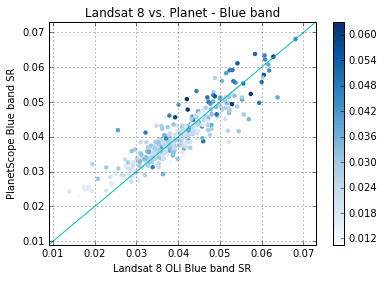

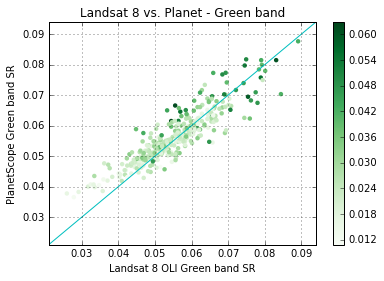

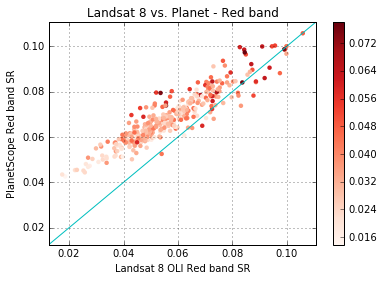

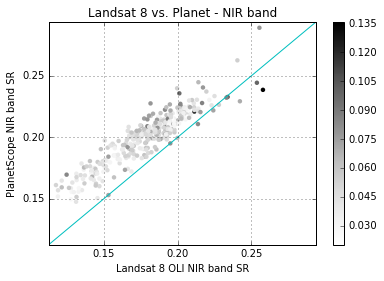

(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
using direct


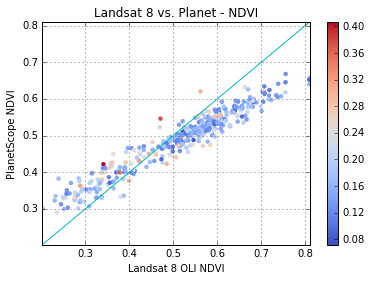

C:\Anaconda2\envs\joemcg_rootclone\lib\site-packages\ipykernel\__main__.py:162: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
C:\Anaconda2\envs\joemcg_rootclone\lib\site-packages\ipykernel\__main__.py:166: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


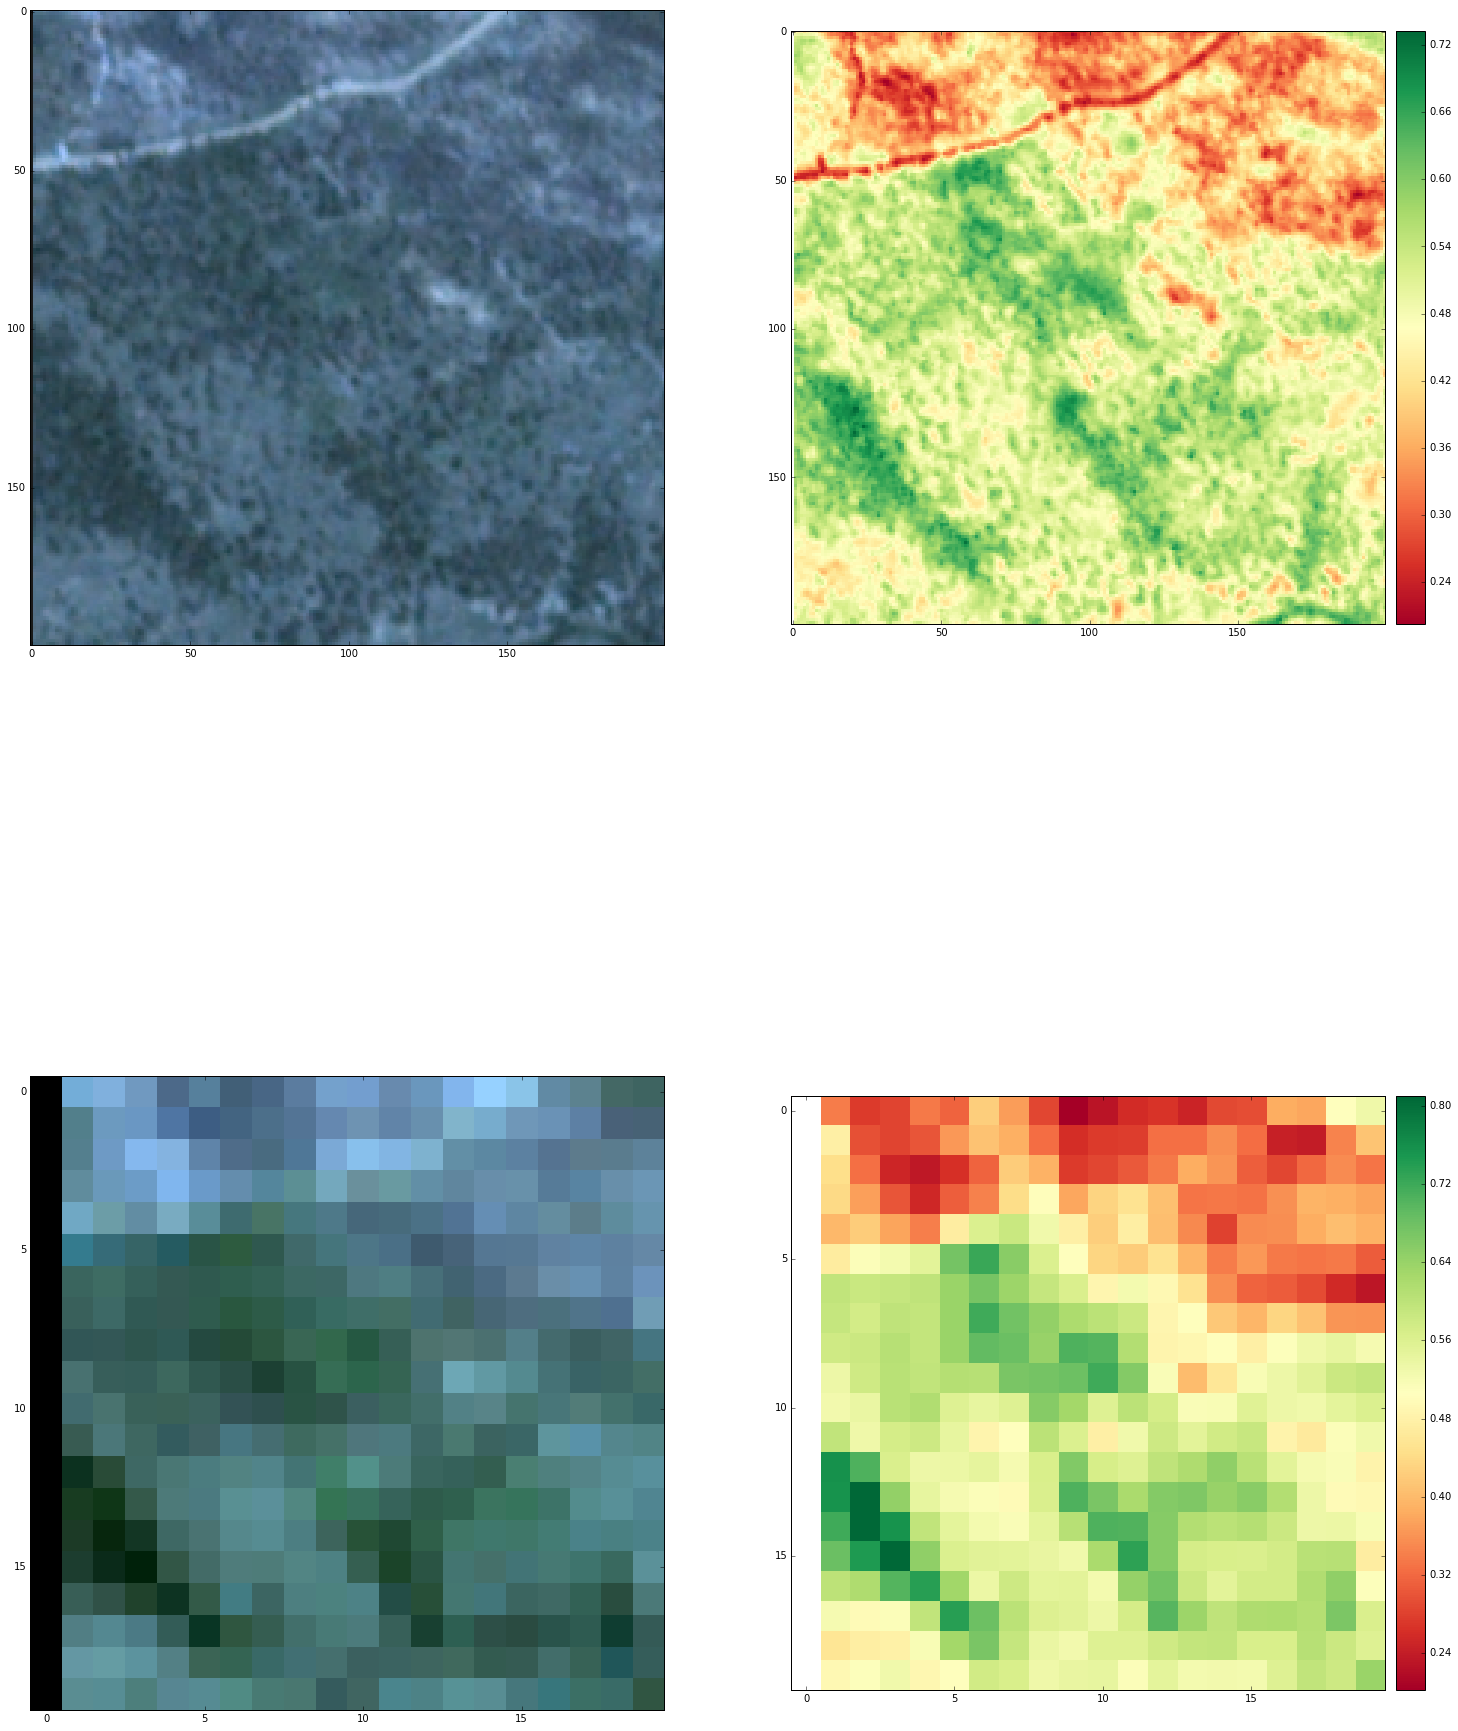

In [8]:
# get the centroids of the polygons and buffer them
# convert to centroids
centroids = [shape(p).centroid for p in polys]

# buffer out buffer_distance*2 meters total. square capping.
buffer_distance = 300.
buffer_p = [c.buffer(buffer_distance, cap_style=3) for c in centroids]

# convert them back to geojson
buffers = [mapping(b) for b in buffer_p]

# read the planet image over the buffered geometries
planet = [meanIntensityOverGeometry_simple(planet_image, planet_xml, p) for p in buffers]

# read the landsat 8 OLI image over the buffered geometries
oli = [meanIntensityOverGeometry_simple_Landsat(landsat_bandfiles, p) for p in buffers]


## get the pixel samples for each band for a given plot
plot_ind = 0
blue_samples = returnSamplesMeanStd(planet[plot_ind]['image'][0,:,:], oli[plot_ind]['image'][0,:,:])
green_samples = returnSamplesMeanStd(planet[plot_ind]['image'][1,:,:], oli[plot_ind]['image'][1,:,:])
red_samples = returnSamplesMeanStd(planet[plot_ind]['image'][2,:,:], oli[plot_ind]['image'][2,:,:])
nir_samples = returnSamplesMeanStd(planet[plot_ind]['image'][3,:,:], oli[plot_ind]['image'][3,:,:])

max_refl = np.max(np.array((blue_samples, green_samples, red_samples, nir_samples)))
min_refl = np.min(np.array((blue_samples, green_samples, red_samples, nir_samples)))

## make some band plots

colors = ['b', 'g', 'r', 'k']
colors = ['Blues', 'Greens', 'Reds', 'Greys']
bands = ['Blue', 'Green', 'Red', 'NIR']
samps = [blue_samples, green_samples, red_samples, nir_samples]
for i, pack in enumerate(zip(samps, bands)):
    
    data, band = pack
    
    # create a new figure and get the axes
    fig = plt.figure()
    ax = plt.gca()
    ax.set_autoscale_on(False)
    
    
    # concatenate the samples
    test = np.hstack(data)
    max_refl = np.max(np.array(test[:2,:]))
    min_refl = np.min(np.array(test[:2,:]))
    
    # set some axis limits
    refl_ext = 0.005
#     plt.ylim(0.0, max_refl + refl_ext)
#     plt.xlim(0.0, max_refl + refl_ext)
    plt.ylim(min_refl - refl_ext, max_refl + refl_ext)
    plt.xlim(min_refl - refl_ext, max_refl + refl_ext)
    
    # scatter plot
#     ax.scatter(test[0,:], test[1,:], color=colors[i])
#     ax.errorbar(test[0,:], test[1,:], yerr=test[2,:], linestyle='none', color = colors[i])
    
    # other scatter plot
    #plt.scatter(test[0,:], test[1,:], alpha=0.75, c=test[2,:], s=test[2,:], edgecolor='none', cmap='bone')
    #plt.scatter(test[0,:], test[1,:], alpha=0.99, c=test[2,:], edgecolor='none', cmap=colors[i]) # colored by std
    plt.scatter(test[0,:], test[1,:], alpha=0.99, c=test[3,:], edgecolor='none', cmap=colors[i]) # colored by range
    
    # get some numbers for a 1:1 line
    #minx, maxx, miny, maxy = test[0,:].min(), test[0,:].max(), test[1,:].min(), test[1,:].max()
    minx, maxx, miny, maxy = 0.0, max_refl + refl_ext, 0.0, max_refl + refl_ext
    extend = 0.01
    #l = mlines.Line2D([minx - extend, maxx + extend], [miny - extend, maxy + extend], color='c')
    l = mlines.Line2D([minx, maxx], [miny, maxy], color='c')
    ax.add_line(l)
    
    plt.grid()
    plt.colorbar()
    
    plt.title('Landsat 8 vs. Planet - {} band'.format(band))
    plt.xlabel('Landsat 8 OLI {} band SR'.format(band))
    plt.ylabel('PlanetScope {} band SR'.format(band))
    plt.show()
    
    fig_name = './work/coloredRANGE_niwot_plot_{}_{}_band_scatter.png'.format(plot_ind, band)
    fig_name = r'C:\Projects\RD\planet\figs\coloredRANGE_niwo_plot_{}_{}_band_scatter.png'.format(plot_ind, band)
    fig.savefig(fig_name)
    
    plt.clf()

    
## do it for NDVI, too
red_stack = np.hstack(red_samples)
nir_stack = np.hstack(nir_samples)

oli_ndvi_num = nir_stack[0,:] - red_stack[0,:]
oli_ndvi_den = nir_stack[0,:] + red_stack[0,:]
oli_ndvi = oli_ndvi_num / oli_ndvi_den

pl_ndvi_num = nir_stack[1,:] - red_stack[1,:]
pl_ndvi_den = nir_stack[1,:] + red_stack[1,:]
pl_ndvi = pl_ndvi_num / pl_ndvi_den

# get the range of ndvi values
max_ndvi = np.max(np.array((pl_ndvi, oli_ndvi)))
min_ndvi = np.min(np.array((pl_ndvi, oli_ndvi)))

# use the function instead
ndvi = returnSamplesMeanStd_ndvi(planet[plot_ind]['image'][2,:,:], 
                                 planet[plot_ind]['image'][3,:,:], 
                                 oli[plot_ind]['image'][2,:,:], 
                                 oli[plot_ind]['image'][3,:,:],
                                method='direct')
ndvi = np.hstack(ndvi)
oli_ndvi = ndvi[0,:]
pl_ndvi = ndvi[1,:]

# create a new figure and get the axes
fig = plt.figure()
ax = plt.gca()
ax.set_autoscale_on(False)

# set some axis limits
ndvi_ext = 0.001
plt.ylim(min_ndvi - ndvi_ext, max_ndvi + ndvi_ext)
plt.xlim(min_ndvi - ndvi_ext, max_ndvi + ndvi_ext)

# scatter plot
#ax.scatter(oli_ndvi, pl_ndvi, color='m')

# other scatter plot
#sc = ax.scatter(oli_ndvi, pl_ndvi, alpha=0.99, c=ndvi[2,:], edgecolor='none', cmap='coolwarm') # colored by std
sc = ax.scatter(oli_ndvi, pl_ndvi, alpha=0.99, c=ndvi[3,:], edgecolor='none', cmap='coolwarm') # colored by range
plt.colorbar(sc)

# get some numbers for a 1:1 line
minx, maxx, miny, maxy = test[0,:].min(), test[0,:].max(), test[1,:].min(), test[1,:].max()
minx, maxx, miny, maxy = min_ndvi - ndvi_ext, max_ndvi + ndvi_ext, min_ndvi - ndvi_ext, max_ndvi + ndvi_ext
extend = 0.01
l = mlines.Line2D([minx - extend, maxx + extend], [miny - extend, maxy + extend], color='c')
ax.add_line(l)

plt.grid()


plt.title('Landsat 8 vs. Planet - NDVI'.format(band))
plt.xlabel('Landsat 8 OLI NDVI')
plt.ylabel('PlanetScope NDVI')
plt.show()

# fig_name = './work/coloredRANGE_niwot_plot_{}_ndvi_scatter.png'.format(plot_ind)
# fig_name = r'C:\Projects\RD\planet\figs\coloredRANGE_niwo_plot_{}_ndvi_scatter.png'.format(plot_ind)
# fig.savefig(fig_name)

plt.clf()


fsize=(25,35)
f, axes = plt.subplots(2, 2, figsize=fsize)
pl_im = np.rollaxis(planet[plot_ind]['image'][:3], 0,3)
pl_ndvi_im = (planet[plot_ind]['image'][3] - planet[plot_ind]['image'][2]) / (planet[plot_ind]['image'][3] + planet[plot_ind]['image'][2])
oli_im = np.rollaxis(oli[plot_ind]['image'][:3], 0, 3)
oli_ndvi_im = (oli[plot_ind]['image'][3] - oli[plot_ind]['image'][2]) / (oli[plot_ind]['image'][3] + oli[plot_ind]['image'][2])

axes[0,0].imshow(misc.bytescale(pl_im), interpolation='nearest', alpha = 0.9)
cf = axes[0,1].imshow(pl_ndvi_im, interpolation='nearest', cmap='RdYlGn')
colorbar(cf)

axes[1,0].imshow(misc.bytescale(oli_im), interpolation='nearest')
cf = axes[1,1].imshow(oli_ndvi_im, interpolation='nearest',cmap='RdYlGn')
colorbar(cf)

fig.tight_layout()

# fig_name = './work/niwot_plot_{}_planet_oli_ndvi_source_res.png'.format(plot_ind)
# fig_name = r'C:\Projects\RD\planet\figs\niwot_plot_{}_planet_oli_ndvi_source_res.png'.format(plot_ind)
# f.savefig(fig_name)

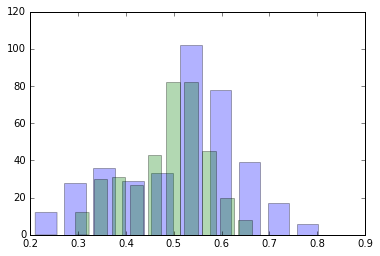

In [9]:
plt.hist(oli_ndvi[oli_ndvi>-9999].ravel(), alpha=0.3, normed=False, color='b', rwidth=0.75)
plt.hist(pl_ndvi.ravel(), alpha=0.3, normed=False, color='g',rwidth=0.75)
plt.show()

In [10]:
min_ndvi - ndvi_ext, max_ndvi + ndvi_ext

(0.20173972602739729, 0.81093150684931514)

In [11]:
ndvi.shape

(4L, 380L)

In [12]:
ndvi2 = returnSamplesMeanStd_ndvi(planet[plot_ind]['image'][2,:,:], 
                                 planet[plot_ind]['image'][3,:,:], 
                                 oli[plot_ind]['image'][2,:,:], 
                                 oli[plot_ind]['image'][3,:,:],
                                 method='lumped+corrfactor')

(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
using lumped+corrfactor


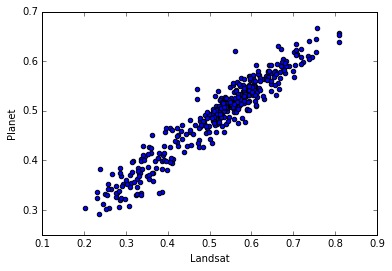

In [13]:
ndvi2=np.array(ndvi2)
plt.scatter(ndvi2[:,0], ndvi2[:,1])
plt.xlabel('Landsat')
plt.ylabel('Planet')

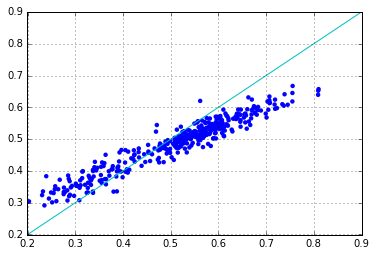

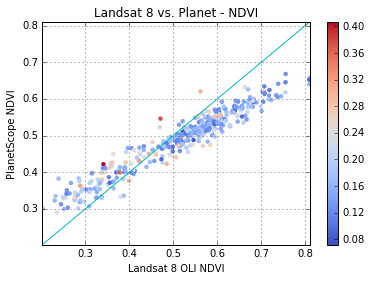

In [14]:
# create a new figure and get the axes
fig = plt.figure()
ax = plt.gca()
ax.set_autoscale_on(False)

# set some axis limits
ndvi_ext = 0.001
plt.ylim(0.2 - ndvi_ext, 0.9 + ndvi_ext)
plt.xlim(0.2 - ndvi_ext, 0.9 + ndvi_ext)

#sc = ax.scatter(oli_ndvi, pl_ndvi, alpha=0.99, c=ndvi[2,:], edgecolor='none', cmap='coolwarm') # colored by std
sc = ax.scatter(ndvi2[:,0], ndvi2[:,1], alpha=0.99, edgecolor='none') 
# plt.colorbar(sc)

# get some numbers for a 1:1 line
minx, maxx, miny, maxy = ndvi2[0,:].min(), ndvi2[0,:].max(), ndvi2[1,:].min(), ndvi2[1,:].max()
minx, maxx, miny, maxy = 0.2 - ndvi_ext, 0.9 + ndvi_ext, 0.2 - ndvi_ext, 0.9 + ndvi_ext
extend = 0.01
l = mlines.Line2D([minx - extend, maxx + extend], [miny - extend, maxy + extend], color='c')
ax.add_line(l)

plt.grid()



####################
# original
# create a new figure and get the axes
fig = plt.figure()
ax = plt.gca()
ax.set_autoscale_on(False)

# set some axis limits
ndvi_ext = 0.001
plt.ylim(min_ndvi - ndvi_ext, max_ndvi + ndvi_ext)
plt.xlim(min_ndvi - ndvi_ext, max_ndvi + ndvi_ext)

# scatter plot
#ax.scatter(oli_ndvi, pl_ndvi, color='m')

# other scatter plot
#sc = ax.scatter(oli_ndvi, pl_ndvi, alpha=0.99, c=ndvi[2,:], edgecolor='none', cmap='coolwarm') # colored by std
sc = ax.scatter(oli_ndvi, pl_ndvi, alpha=0.99, c=ndvi[3,:], edgecolor='none', cmap='coolwarm') # colored by range
plt.colorbar(sc)

# get some numbers for a 1:1 line
minx, maxx, miny, maxy = test[0,:].min(), test[0,:].max(), test[1,:].min(), test[1,:].max()
minx, maxx, miny, maxy = min_ndvi - ndvi_ext, max_ndvi + ndvi_ext, min_ndvi - ndvi_ext, max_ndvi + ndvi_ext
extend = 0.01
l = mlines.Line2D([minx - extend, maxx + extend], [miny - extend, maxy + extend], color='c')
ax.add_line(l)

plt.grid()


plt.title('Landsat 8 vs. Planet - NDVI'.format(band))
plt.xlabel('Landsat 8 OLI NDVI')
plt.ylabel('PlanetScope NDVI')
plt.show()

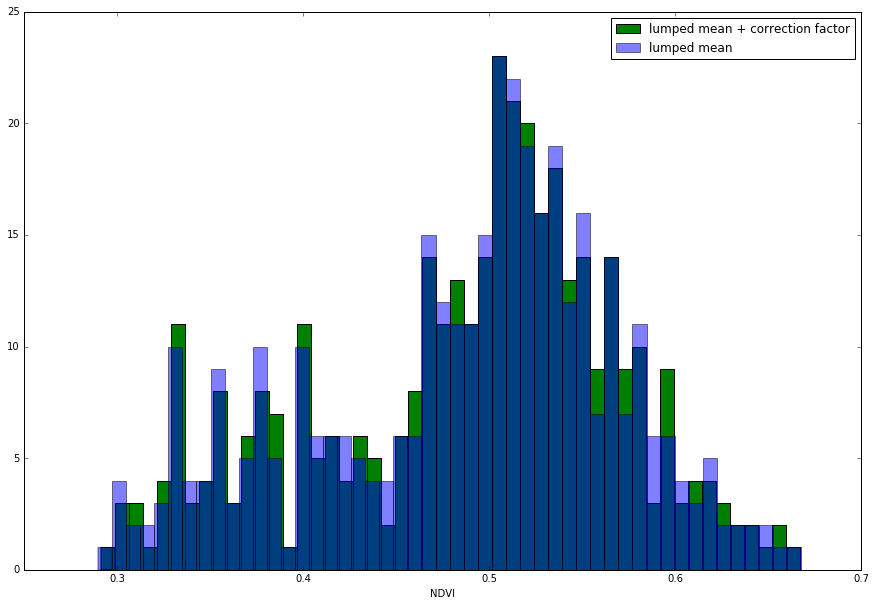

In [15]:
plt.figure(figsize=(15,10))
plt.hist(ndvi2[:,1], bins=50, label='lumped mean + correction factor', color='g')
plt.hist(ndvi[1,:], bins=50, alpha=0.5, label='lumped mean')
plt.legend()
plt.xlabel('NDVI')
plt.show()



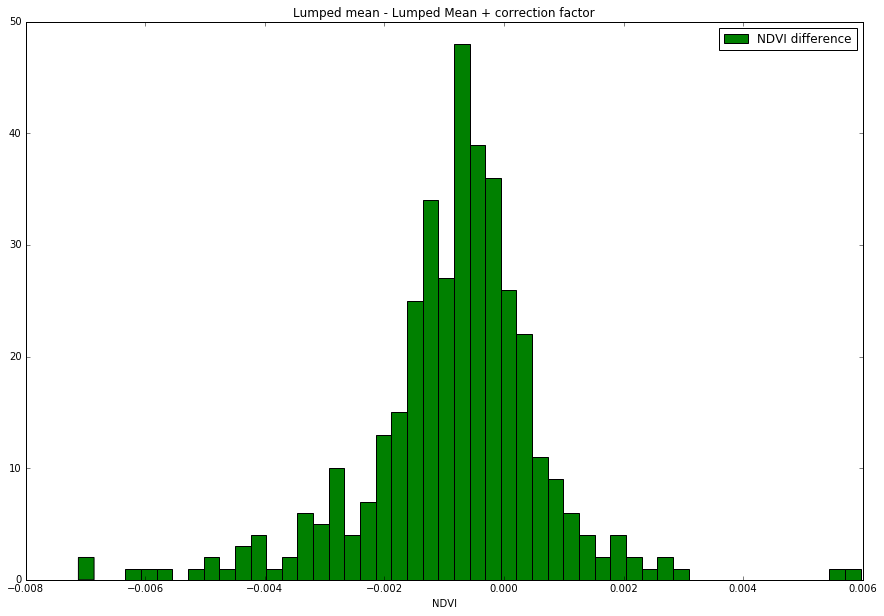

In [16]:
plt.figure(figsize=(15,10))
plt.hist(ndvi[1,:] - ndvi2[:,1], bins=50, label='NDVI difference', color='g')
plt.title('Lumped mean - Lumped Mean + correction factor')
plt.legend()
plt.xlabel('NDVI')
plt.show()


#### try the Smax correction

In [17]:
plot_ind=0

In [18]:
ndvi = returnSamplesMeanStd_ndvi(planet[plot_ind]['image'][2,:,:], 
                                 planet[plot_ind]['image'][3,:,:], 
                                 oli[plot_ind]['image'][2,:,:], 
                                 oli[plot_ind]['image'][3,:,:],
                                 method='direct')
ndvi = np.array(ndvi).squeeze()

(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
using direct


In [19]:
ndvi2 = returnSamplesMeanStd_ndvi(planet[plot_ind]['image'][2,:,:], 
                                 planet[plot_ind]['image'][3,:,:], 
                                 oli[plot_ind]['image'][2,:,:], 
                                 oli[plot_ind]['image'][3,:,:],
                                 method='lumped+corrfactor')
ndvi2=np.array(ndvi2)

(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
using lumped+corrfactor


In [20]:
print("'corr_factor: ', corr_factor, R1_bar, R1_min, R1_max, R2_min, R2_max, NA1, NA2, Smax_1, Smax_2")
ndvi3 = returnSamplesMeanStd_ndvi(planet[plot_ind]['image'][2,:,:], 
                                 planet[plot_ind]['image'][3,:,:], 
                                 oli[plot_ind]['image'][2,:,:], 
                                 oli[plot_ind]['image'][3,:,:],
                                 method='Smax')
ndvi3=np.array(ndvi3)

'corr_factor: ', corr_factor, R1_bar, R1_min, R1_max, R2_min, R2_max, NA1, NA2, Smax_1, Smax_2
(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
using Smax


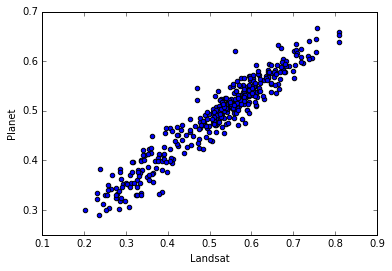

In [21]:

plt.scatter(ndvi3[:,0], ndvi3[:,1])
plt.xlabel('Landsat')
plt.ylabel('Planet')

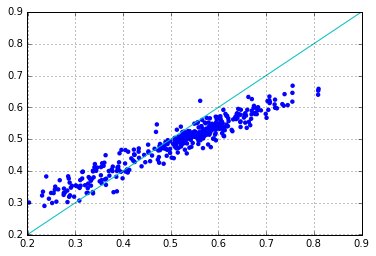

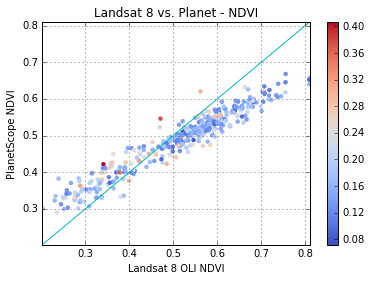

In [22]:
# create a new figure and get the axes
fig = plt.figure()
ax = plt.gca()
ax.set_autoscale_on(False)

# set some axis limits
ndvi_ext = 0.001
plt.ylim(0.2 - ndvi_ext, 0.9 + ndvi_ext)
plt.xlim(0.2 - ndvi_ext, 0.9 + ndvi_ext)

#sc = ax.scatter(oli_ndvi, pl_ndvi, alpha=0.99, c=ndvi[2,:], edgecolor='none', cmap='coolwarm') # colored by std
sc = ax.scatter(ndvi3[:,0], ndvi3[:,1], alpha=0.99, edgecolor='none') 
# plt.colorbar(sc)

# get some numbers for a 1:1 line
minx, maxx, miny, maxy = ndvi3[0,:].min(), ndvi3[0,:].max(), ndvi3[1,:].min(), ndvi3[1,:].max()
minx, maxx, miny, maxy = 0.2 - ndvi_ext, 0.9 + ndvi_ext, 0.2 - ndvi_ext, 0.9 + ndvi_ext
extend = 0.01
l = mlines.Line2D([minx - extend, maxx + extend], [miny - extend, maxy + extend], color='c')
ax.add_line(l)

plt.grid()



####################
# original
# create a new figure and get the axes
fig = plt.figure()
ax = plt.gca()
ax.set_autoscale_on(False)

# set some axis limits
ndvi_ext = 0.001
plt.ylim(min_ndvi - ndvi_ext, max_ndvi + ndvi_ext)
plt.xlim(min_ndvi - ndvi_ext, max_ndvi + ndvi_ext)

# scatter plot
#ax.scatter(oli_ndvi, pl_ndvi, color='m')

# other scatter plot
#sc = ax.scatter(oli_ndvi, pl_ndvi, alpha=0.99, c=ndvi[2,:], edgecolor='none', cmap='coolwarm') # colored by std
sc = ax.scatter(oli_ndvi, pl_ndvi, alpha=0.99, c=ndvi[:,3], edgecolor='none', cmap='coolwarm') # colored by range
plt.colorbar(sc)

# get some numbers for a 1:1 line
minx, maxx, miny, maxy = test[0,:].min(), test[0,:].max(), test[1,:].min(), test[1,:].max()
minx, maxx, miny, maxy = min_ndvi - ndvi_ext, max_ndvi + ndvi_ext, min_ndvi - ndvi_ext, max_ndvi + ndvi_ext
extend = 0.01
l = mlines.Line2D([minx - extend, maxx + extend], [miny - extend, maxy + extend], color='c')
ax.add_line(l)

plt.grid()


plt.title('Landsat 8 vs. Planet - NDVI'.format(band))
plt.xlabel('Landsat 8 OLI NDVI')
plt.ylabel('PlanetScope NDVI')
plt.show()

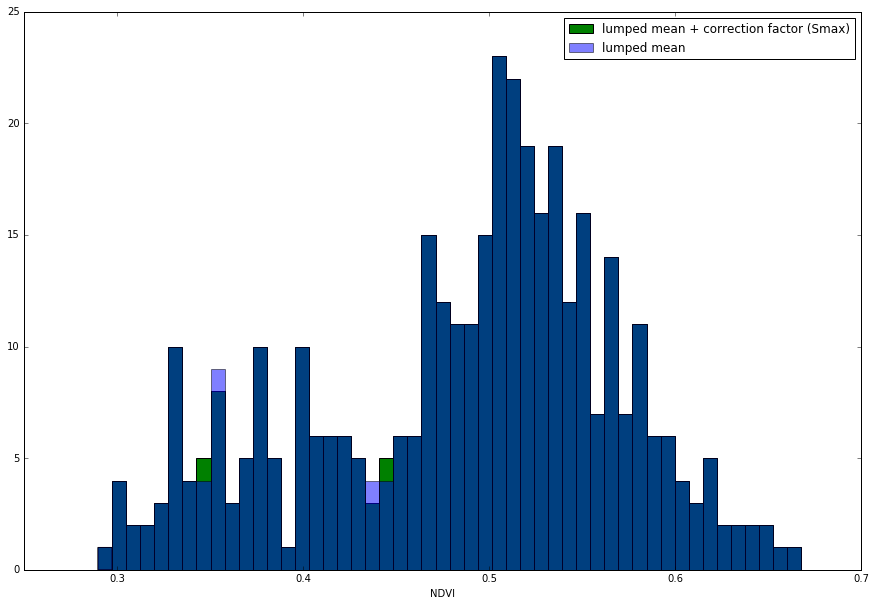

In [23]:
plt.figure(figsize=(15,10))
plt.hist(ndvi3[:,1], bins=50, label='lumped mean + correction factor (Smax)', color='g')
plt.hist(ndvi[:,1], bins=50, alpha=0.5, label='lumped mean')
plt.legend()
plt.xlabel('NDVI')
plt.show()



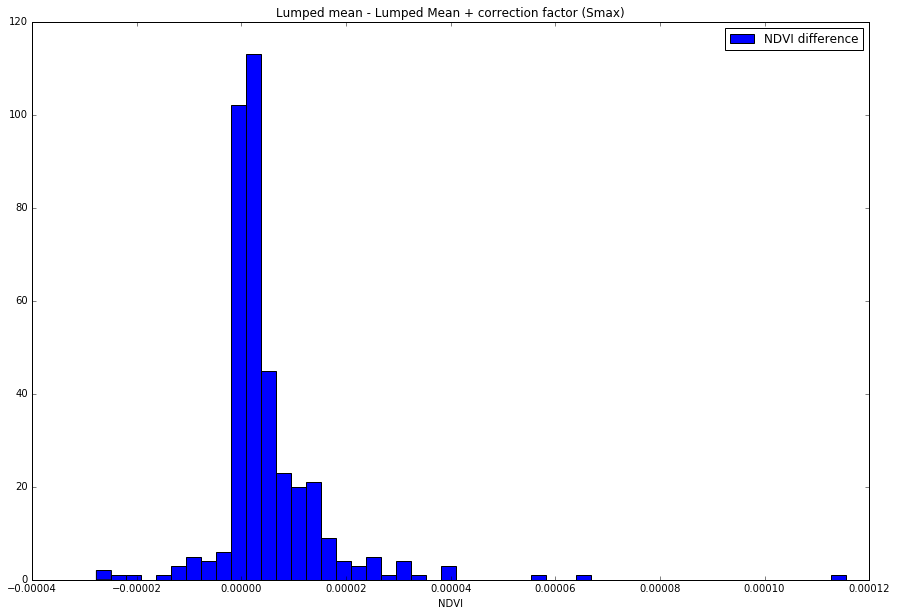

In [24]:
plt.figure(figsize=(15,10))
plt.hist(ndvi[:,1] - ndvi3[:,1], bins=50, label='NDVI difference')
plt.title('Lumped mean - Lumped Mean + correction factor (Smax)')
plt.legend()
plt.xlabel('NDVI')
plt.show()


### look at all three


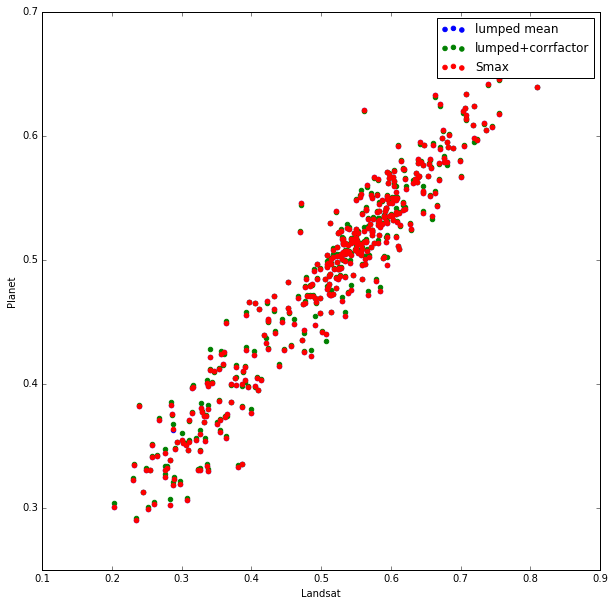

In [25]:
plt.figure(figsize=(10,10))
plt.scatter(ndvi[:,0], ndvi[:,1], label='lumped mean', color='b')
plt.scatter(ndvi2[:,0], ndvi2[:,1], label='lumped+corrfactor', color='g')
plt.scatter(ndvi3[:,0], ndvi3[:,1], label='Smax', color='r')
plt.legend()
plt.xlabel('Landsat')
plt.ylabel('Planet')

max lumped+corrfactor: 0.00711930916828
max Smax: 0.169403176515


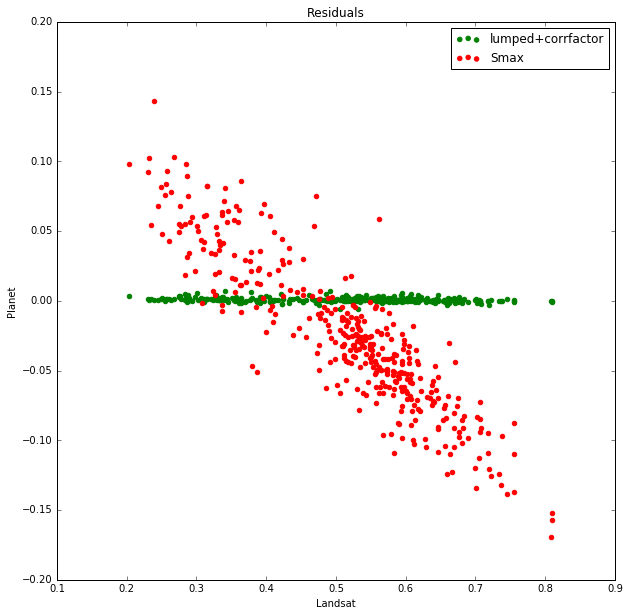

In [26]:
## plot residuals from lumped mean
lumped_mean_corr_factor_resids = ndvi2[:,1] - ndvi[:,1]
range1 = np.arange(lumped_mean_corr_factor_resids.size)
smax_resids = ndvi3[:,1] - ndvi[:,0]
range2 = np.arange(smax_resids.size)

print('max lumped+corrfactor: {}'.format(np.abs(lumped_mean_corr_factor_resids).max()))
print('max Smax: {}'.format(np.abs(smax_resids).max()))

plt.figure(figsize=(10,10))
plt.scatter(ndvi[:,0], lumped_mean_corr_factor_resids, label='lumped+corrfactor', color='g')
plt.scatter(ndvi[:,0], smax_resids, label='Smax', color='r')
plt.legend()
plt.xlabel('Landsat')
plt.ylabel('Planet')
plt.title('Residuals')

### look at the ndvi results as images, and residuals

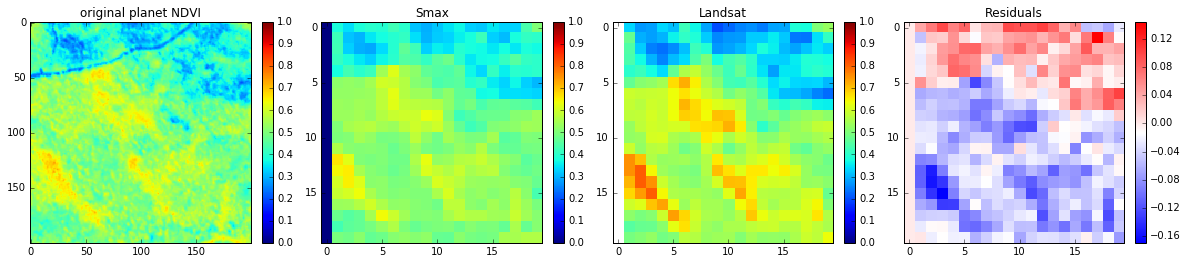

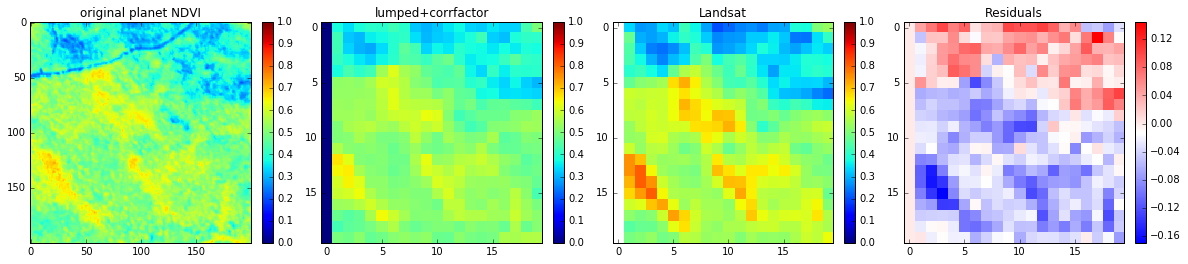

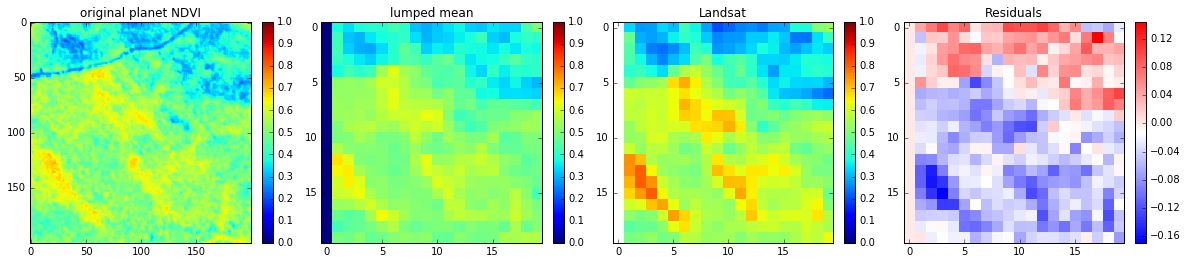

In [27]:
ndvi3_im = np.zeros(oli_ndvi_im.shape)
ndvi3_im[oli_ndvi_im>0] = ndvi3[:,1]
ndvi3_resid_im = np.zeros(oli_ndvi_im.shape)
ndvi3_resid_im[oli_ndvi_im>0] = ndvi3[:,1] - ndvi3[:,0]

plt.figure(figsize=(20,10))
plt.subplot(141)
cf = plt.imshow(pl_ndvi_im, interpolation='nearest', vmin=0., vmax=1.0)
plt.title('original planet NDVI')
colorbar(cf)
plt.subplot(142)
cf = plt.imshow(ndvi3_im, interpolation='nearest', vmin=0., vmax=1.0)
plt.title('Smax')
colorbar(cf)
plt.subplot(143)
cf = plt.imshow(oli_ndvi_im, interpolation='nearest', vmin=0., vmax=1.0)
plt.title('Landsat')
colorbar(cf)
plt.subplot(144)
cf = plt.imshow(ndvi3_resid_im, interpolation='nearest', cmap='bwr')
plt.title('Residuals')
colorbar(cf)
plt.show()

ndvi2_im = np.zeros(oli_ndvi_im.shape)
ndvi2_im[oli_ndvi_im>0] = ndvi2[:,1]
ndvi2_resid_im = np.zeros(oli_ndvi_im.shape)
ndvi2_resid_im[oli_ndvi_im>0] = ndvi2[:,1] - ndvi2[:,0]

plt.figure(figsize=(20,10))
plt.subplot(141)
cf = plt.imshow(pl_ndvi_im, interpolation='nearest', vmin=0., vmax=1.0)
plt.title('original planet NDVI')
colorbar(cf)

plt.subplot(142)
cf = plt.imshow(ndvi2_im, interpolation='nearest', vmin=0., vmax=1.0)
plt.title('lumped+corrfactor')
colorbar(cf)
plt.subplot(143)
cf = plt.imshow(oli_ndvi_im, interpolation='nearest', vmin=0., vmax=1.0)
plt.title('Landsat')
colorbar(cf)
plt.subplot(144)
cf = plt.imshow(ndvi2_resid_im, interpolation='nearest', cmap='bwr')
plt.title('Residuals')
colorbar(cf)
plt.show()

ndvi1_im = np.zeros(oli_ndvi_im.shape)
ndvi1_im[oli_ndvi_im>0] = ndvi[:,1]
ndvi1_resid_im = np.zeros(oli_ndvi_im.shape)
ndvi1_resid_im[oli_ndvi_im>0] = ndvi[:,1] - ndvi[:,0]

plt.figure(figsize=(20,10))
plt.subplot(141)
cf = plt.imshow(pl_ndvi_im, interpolation='nearest', vmin=0., vmax=1.0)
plt.title('original planet NDVI')
colorbar(cf)
plt.subplot(142)
cf = plt.imshow(ndvi1_im, interpolation='nearest', vmin=0., vmax=1.0)
plt.title('lumped mean')
colorbar(cf)
plt.subplot(143)
cf = plt.imshow(oli_ndvi_im, interpolation='nearest', vmin=0., vmax=1.0)
plt.title('Landsat')
colorbar(cf)
plt.subplot(144)
cf = plt.imshow(ndvi1_resid_im, interpolation='nearest', cmap='bwr')
plt.title('Residuals')
colorbar(cf)
plt.show()



In [28]:
print('Smax residuals min / max:              {}, {}'.format(ndvi3_resid_im.min(), ndvi3_resid_im.max()))
print('lumped+corrfactor residuals min / max: {}, {}'.format(ndvi2_resid_im.min(), ndvi1_resid_im.max()))
print('lumped mean residuals min / max:       {}, {}'.format(ndvi1_resid_im.min(), ndvi2_resid_im.max()))

Smax residuals min / max:              -0.169403176515, 0.14355478074
lumped+corrfactor residuals min / max: -0.169626203934, 0.143555272312
lumped mean residuals min / max:       -0.169399157749, 0.144312482131


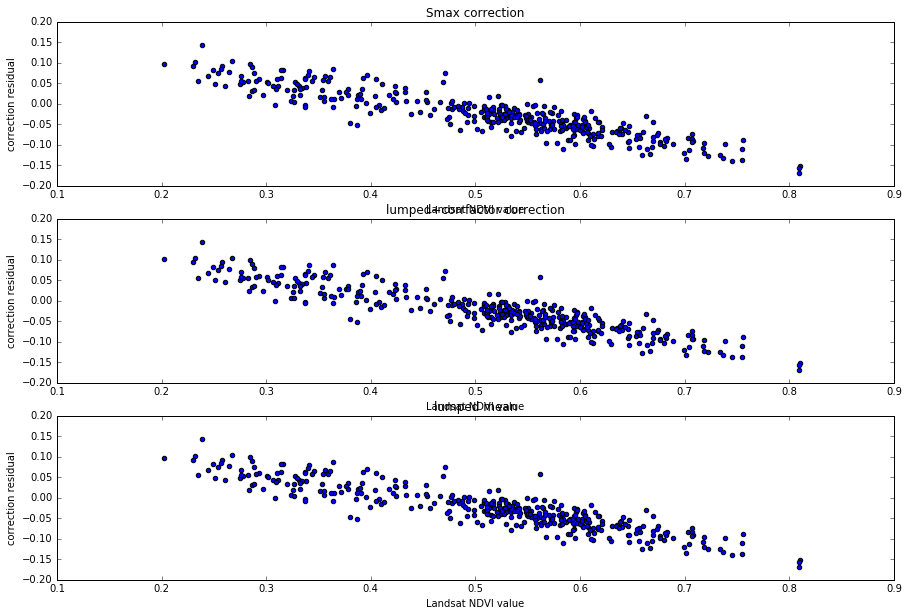

In [29]:
## plot the residuals
plt.figure(figsize=(15,10))
plt.subplot(311)
plt.scatter(ndvi3[:,0], ndvi3[:,1] - ndvi3[:,0])
plt.title('Smax correction')
plt.xlabel('Landsat NDVI value')
plt.ylabel('correction residual')
plt.subplot(312)
plt.scatter(ndvi2[:,0], ndvi2[:,1] - ndvi2[:,0])
plt.title('lumped+corrfactor correction')
plt.xlabel('Landsat NDVI value')
plt.ylabel('correction residual')
plt.subplot(313)
plt.scatter(ndvi[:,0], ndvi[:,1] - ndvi[:,0])
plt.title('lumped mean')
plt.xlabel('Landsat NDVI value')
plt.ylabel('correction residual')
plt.show()


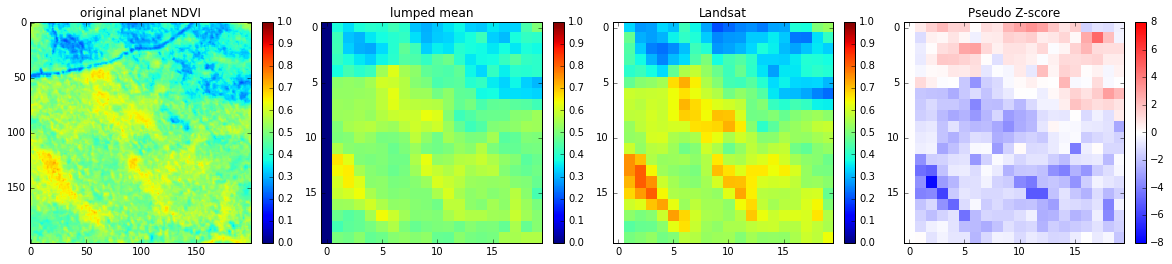

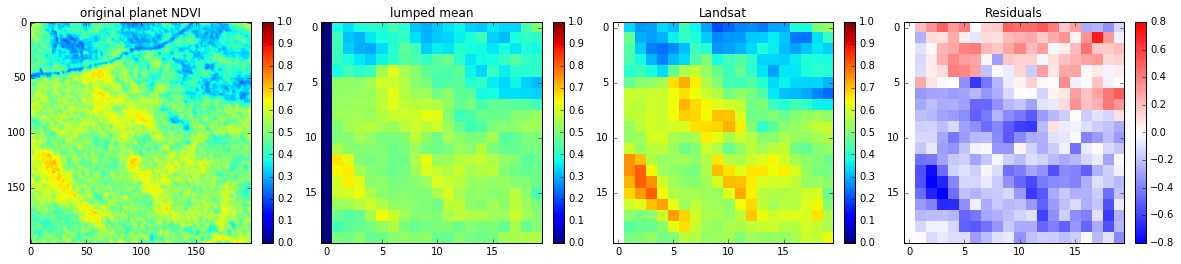

In [30]:
## take a look at a pseudo z score
pz = (ndvi[:,1] - ndvi[:,0]) / ndvi[:,2]
pz_im = np.zeros(oli_ndvi_im.shape)
pz_im[oli_ndvi_im>0] = pz

plt.figure(figsize=(20,10))
plt.subplot(141)
cf = plt.imshow(pl_ndvi_im, interpolation='nearest', vmin=0., vmax=1.0)
plt.title('original planet NDVI')
colorbar(cf)
plt.subplot(142)
cf = plt.imshow(ndvi1_im, interpolation='nearest', vmin=0., vmax=1.0)
plt.title('lumped mean')
colorbar(cf)
plt.subplot(143)
cf = plt.imshow(oli_ndvi_im, interpolation='nearest', vmin=0., vmax=1.0)
plt.title('Landsat')
colorbar(cf)
plt.subplot(144)
cf = plt.imshow(pz_im, interpolation='nearest', cmap='bwr', vmin=-8, vmax=8)
plt.title('Pseudo Z-score')
colorbar(cf)
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(141)
cf = plt.imshow(pl_ndvi_im, interpolation='nearest', vmin=0., vmax=1.0)
plt.title('original planet NDVI')
colorbar(cf)
plt.subplot(142)
cf = plt.imshow(ndvi1_im, interpolation='nearest', vmin=0., vmax=1.0)
plt.title('lumped mean')
colorbar(cf)
plt.subplot(143)
cf = plt.imshow(oli_ndvi_im, interpolation='nearest', vmin=0., vmax=1.0)
plt.title('Landsat')
colorbar(cf)
plt.subplot(144)
cf = plt.imshow(ndvi1_resid_im*5., interpolation='nearest', cmap='bwr', vmin=-.8, vmax=0.8)
plt.title('Residuals')
colorbar(cf)
plt.show()


## Iterate through the geometries to show the NDVI plots

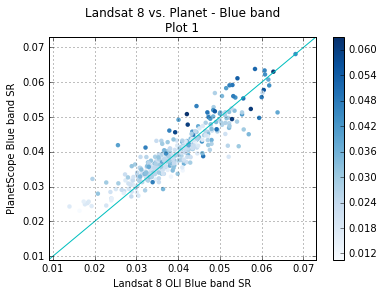

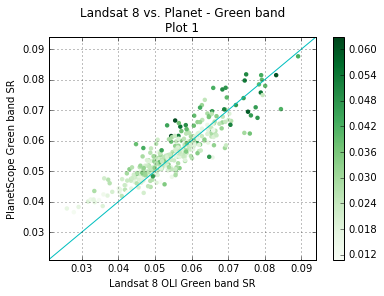

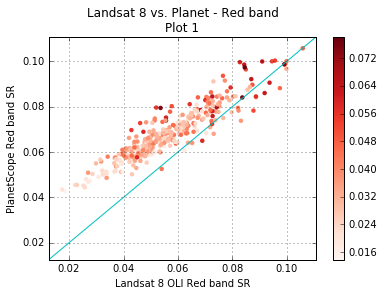

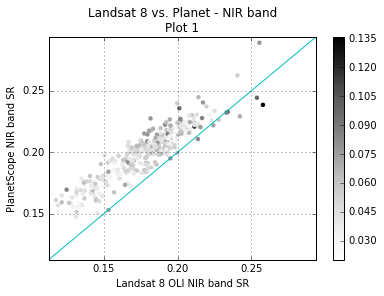

(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
using direct


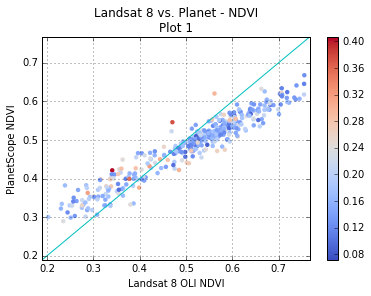

C:\Anaconda2\envs\joemcg_rootclone\lib\site-packages\ipykernel\__main__.py:122: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
C:\Anaconda2\envs\joemcg_rootclone\lib\site-packages\ipykernel\__main__.py:128: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


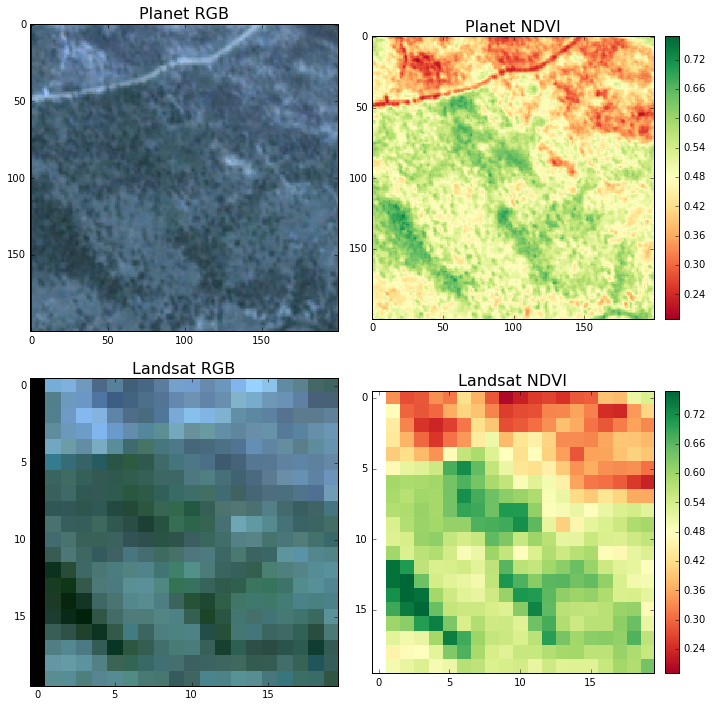

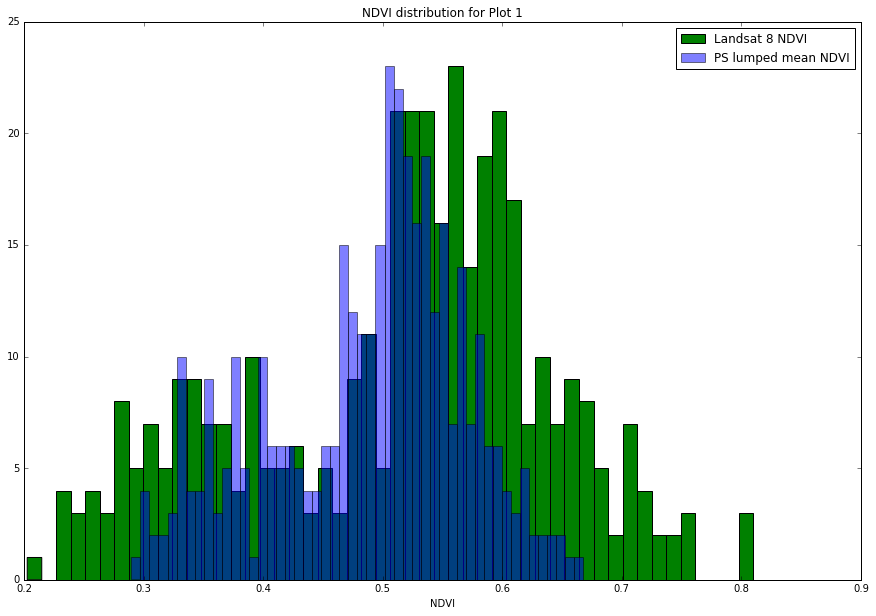

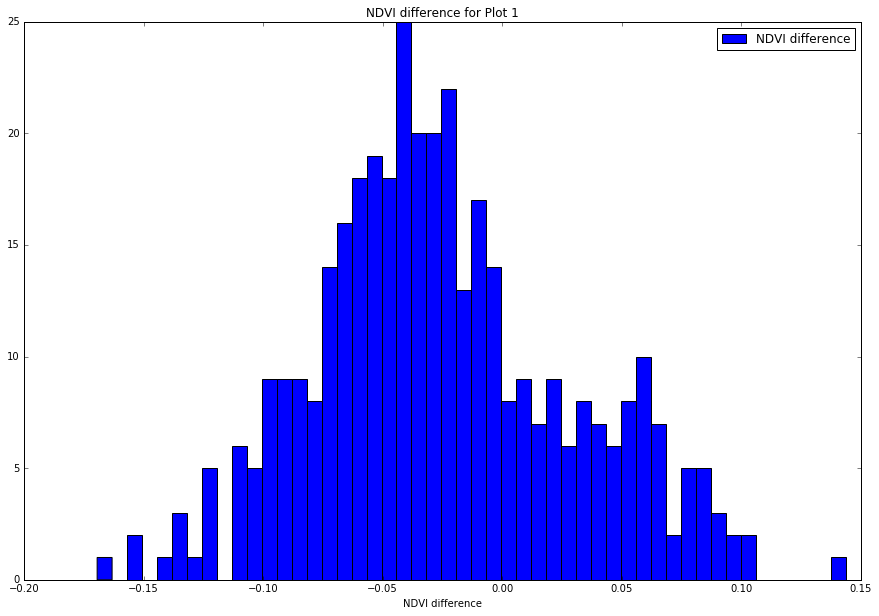

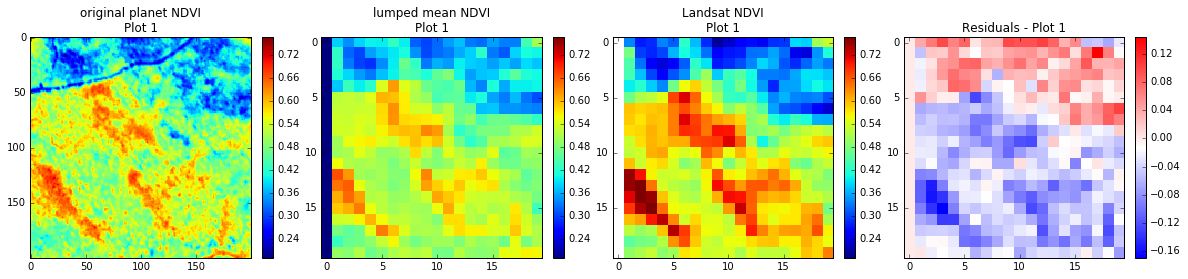

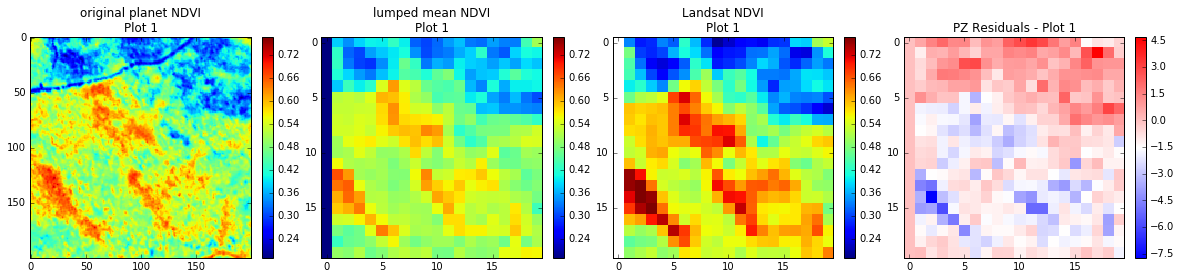

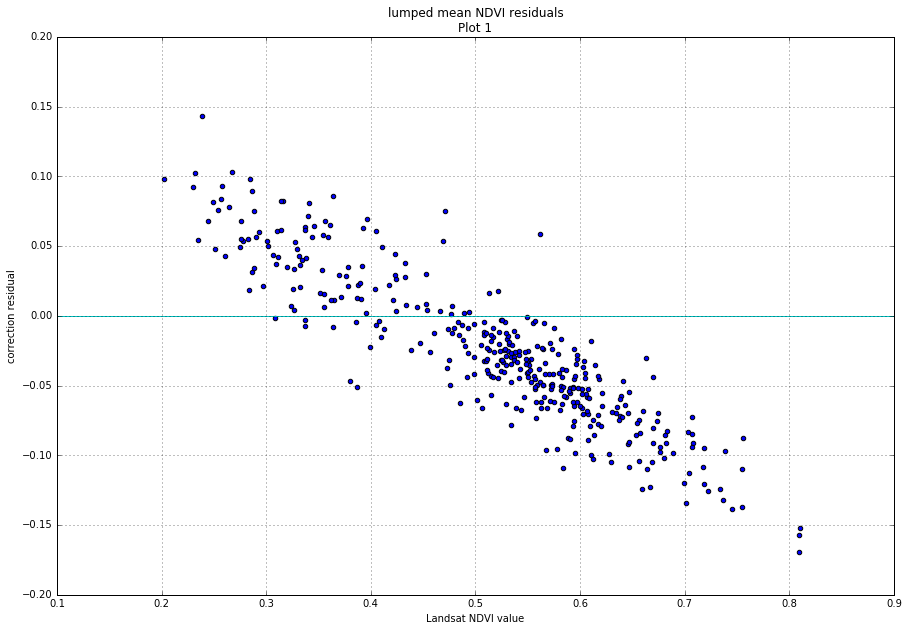

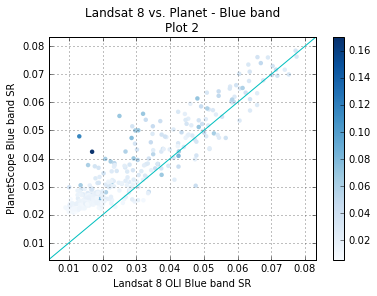

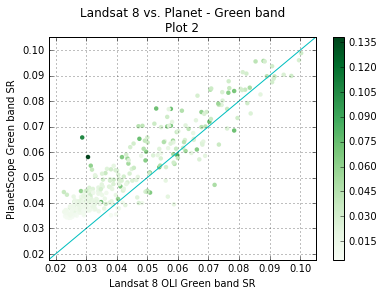

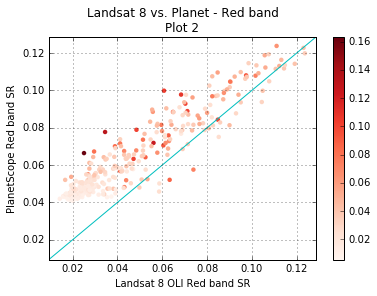

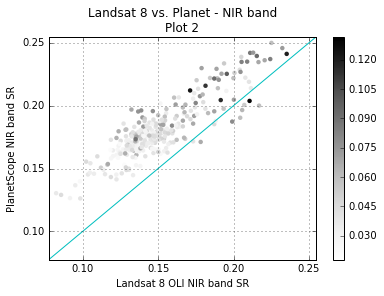

(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
using direct


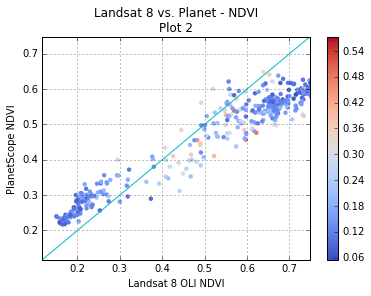

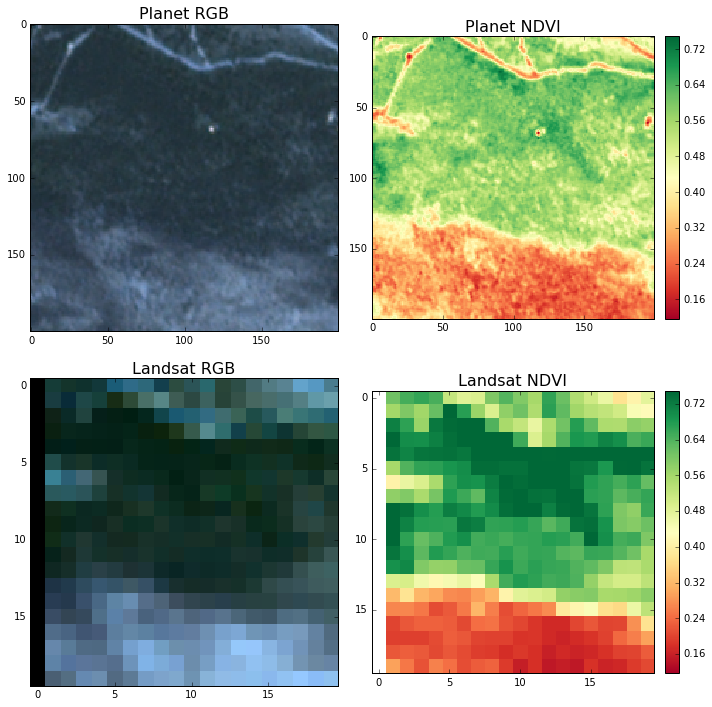

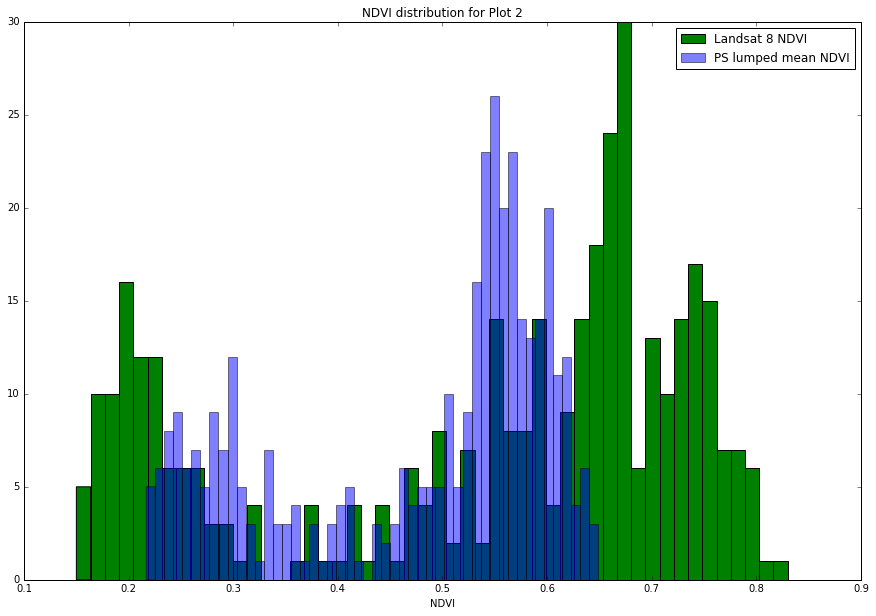

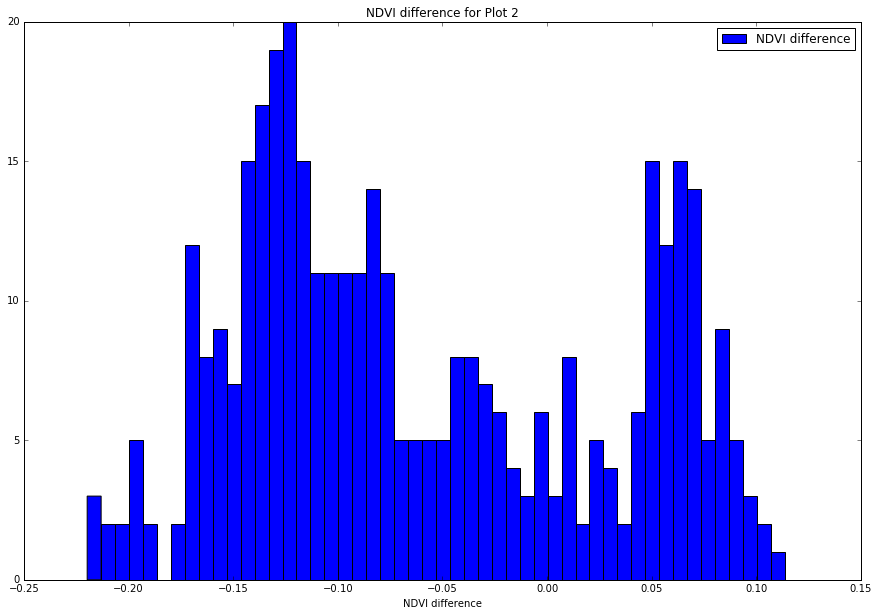

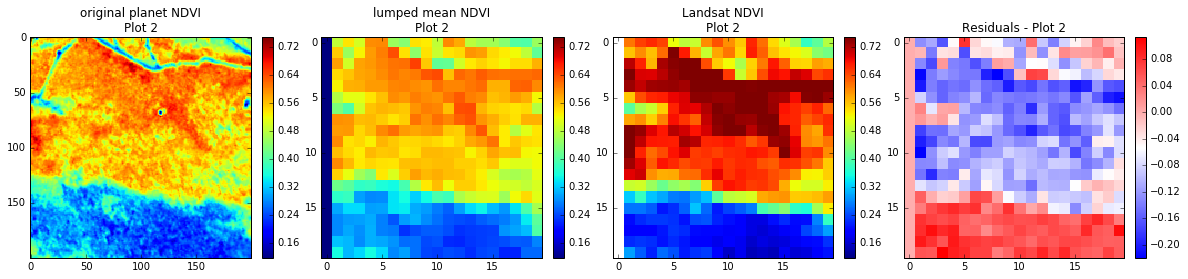

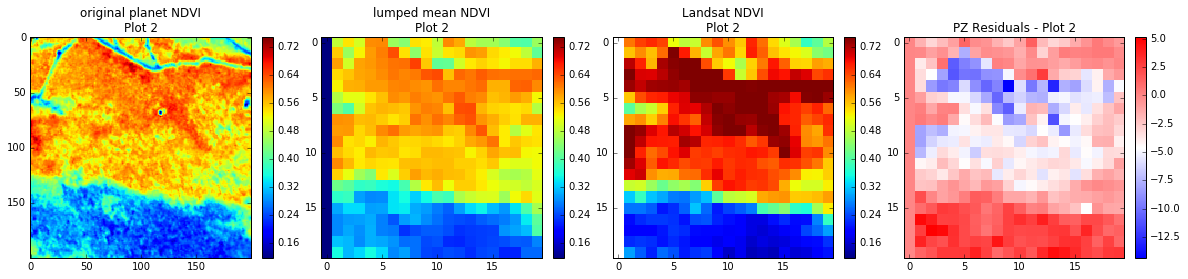

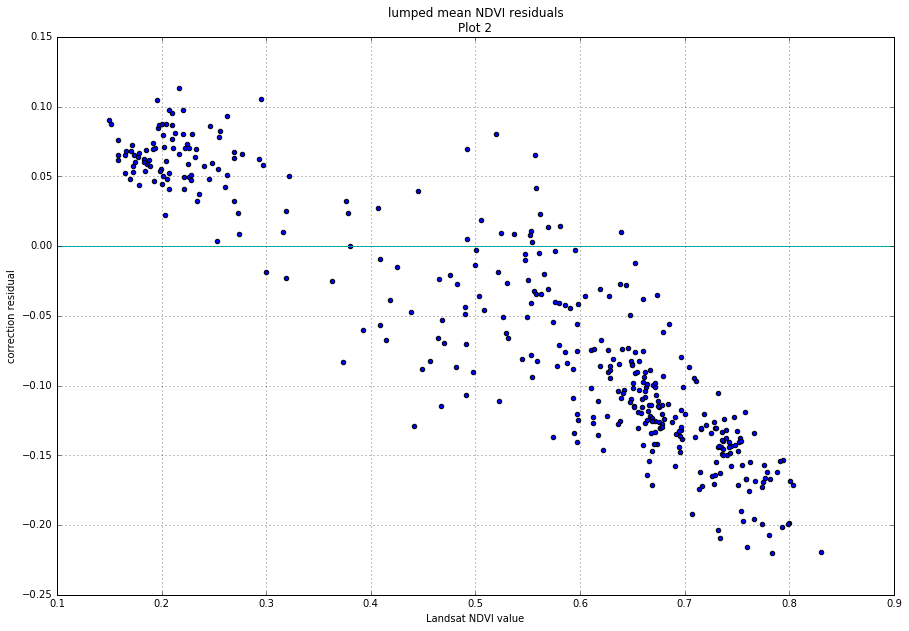

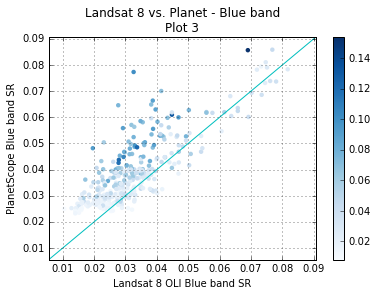

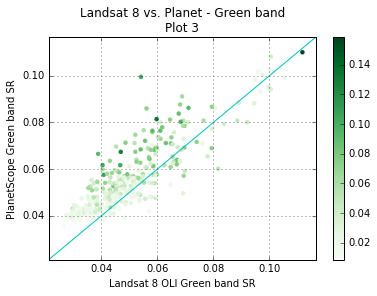

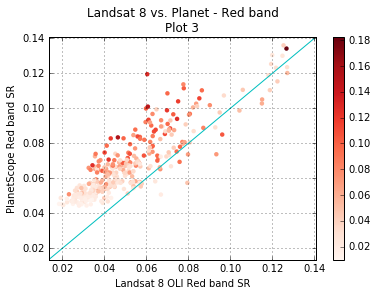

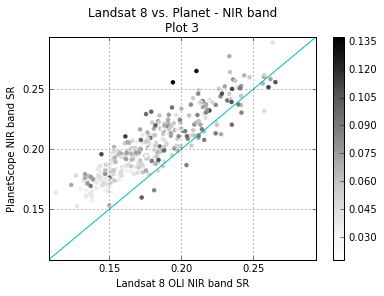

(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
using direct


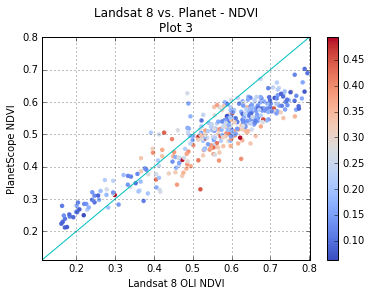

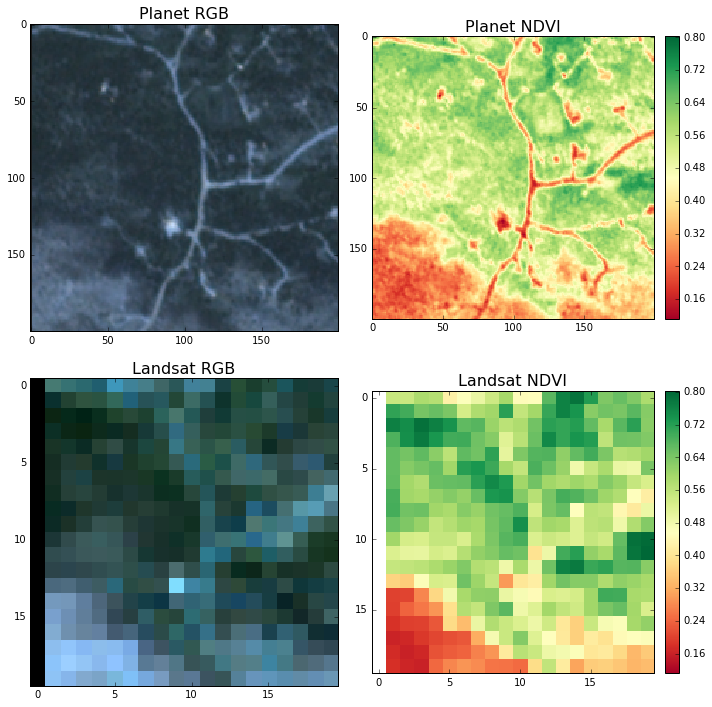

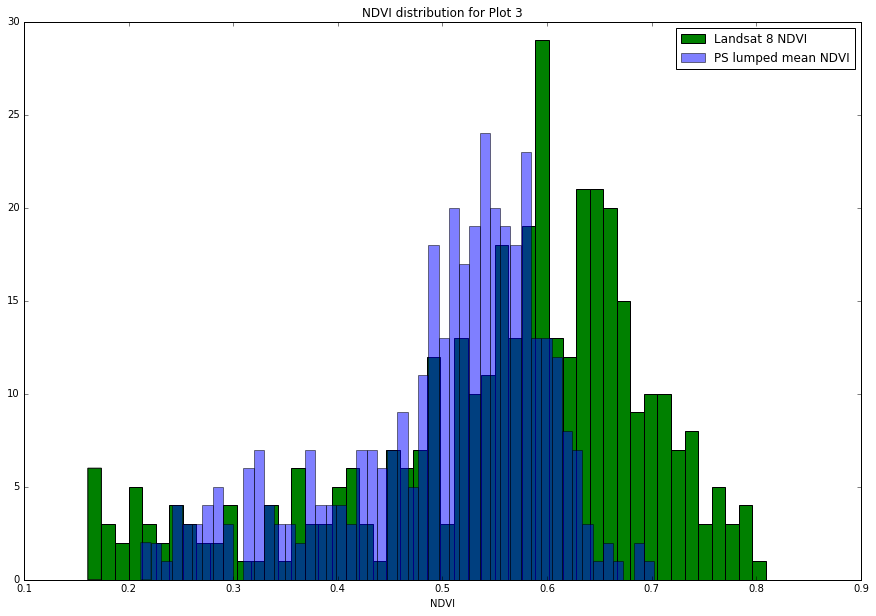

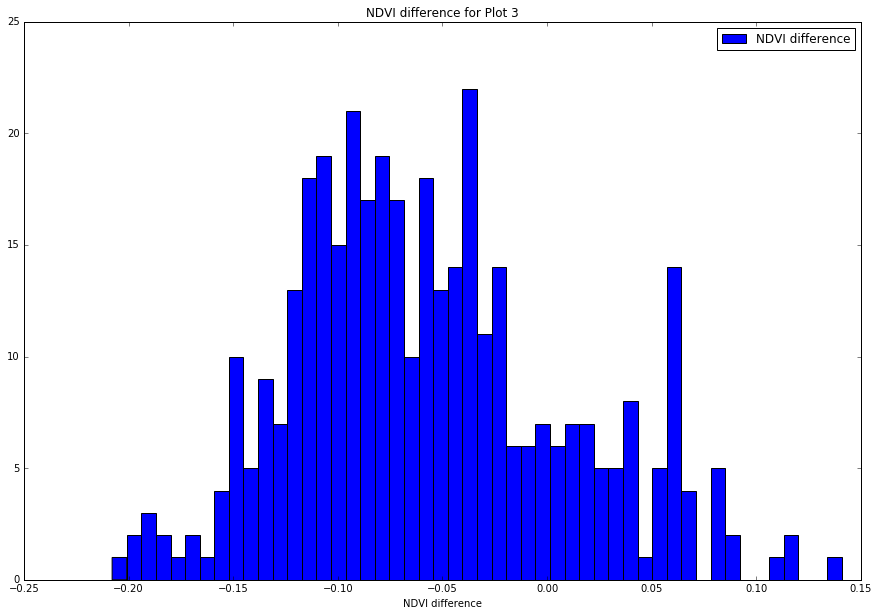

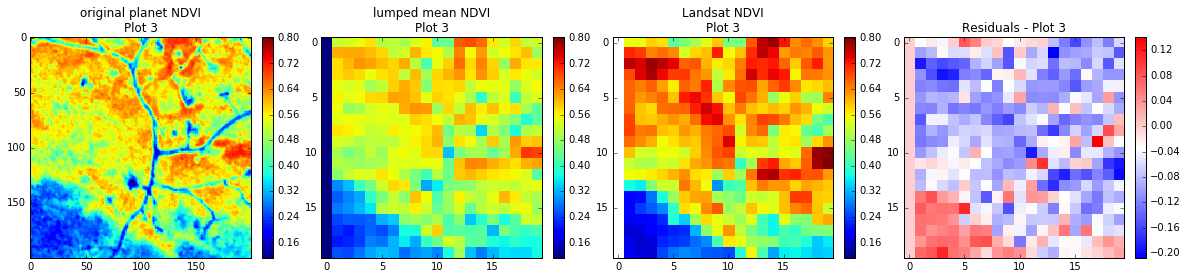

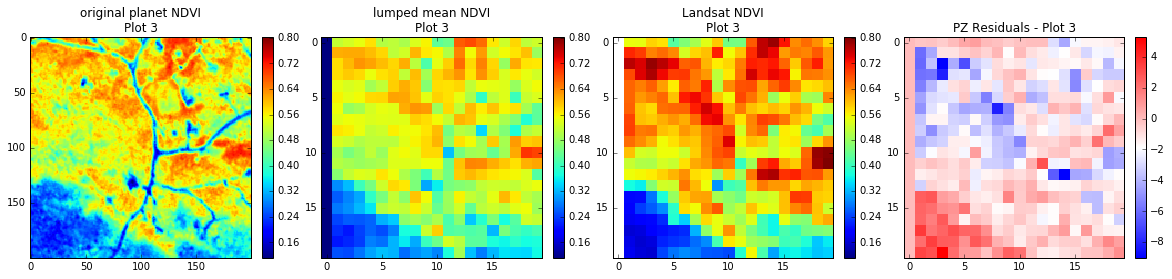

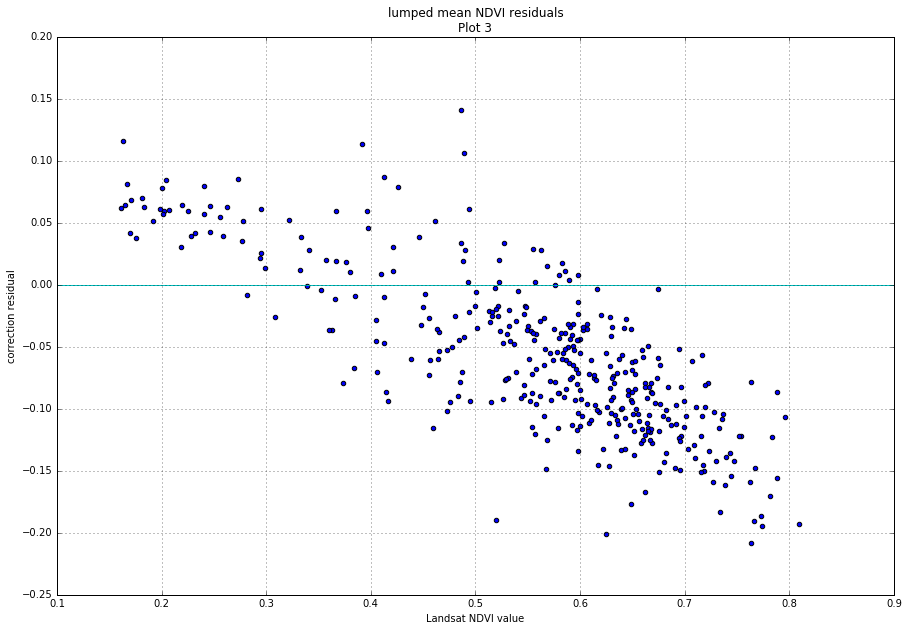

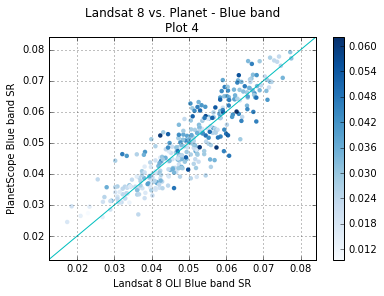

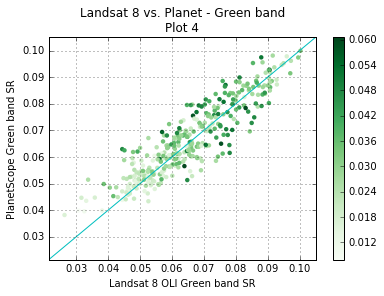

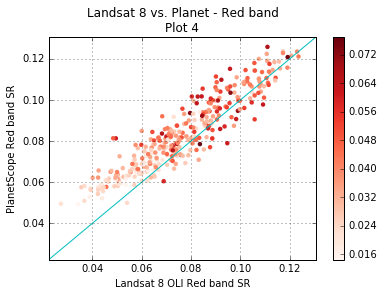

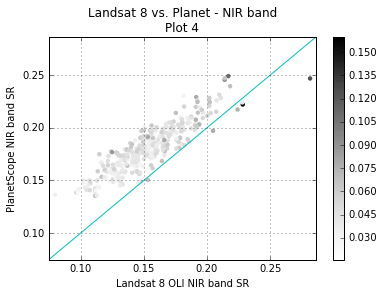

(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
using direct


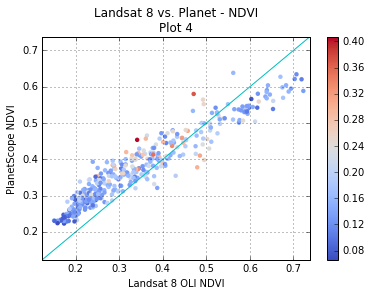

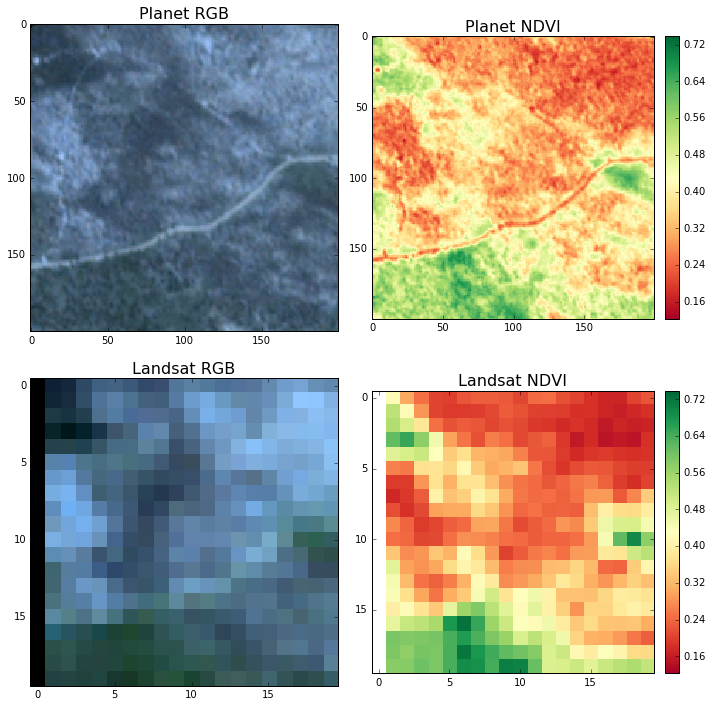

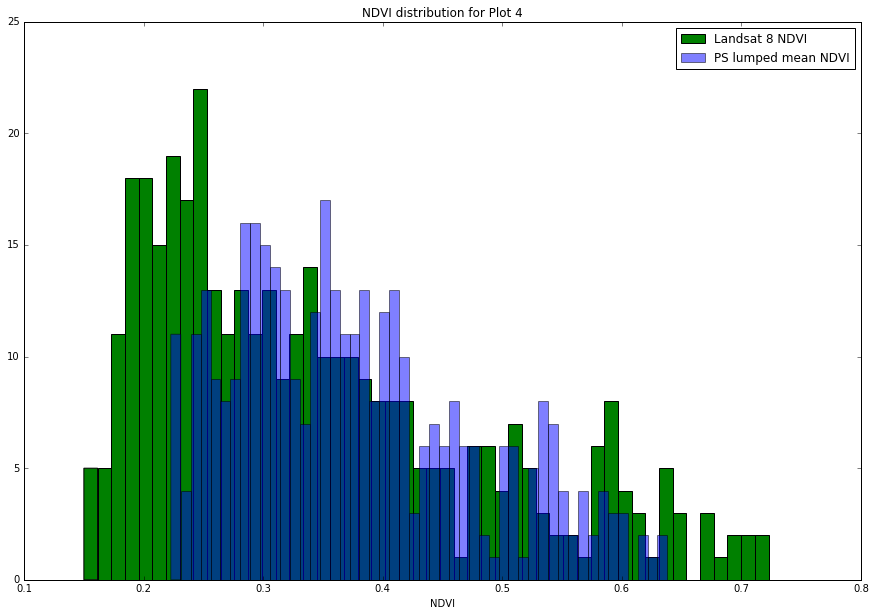

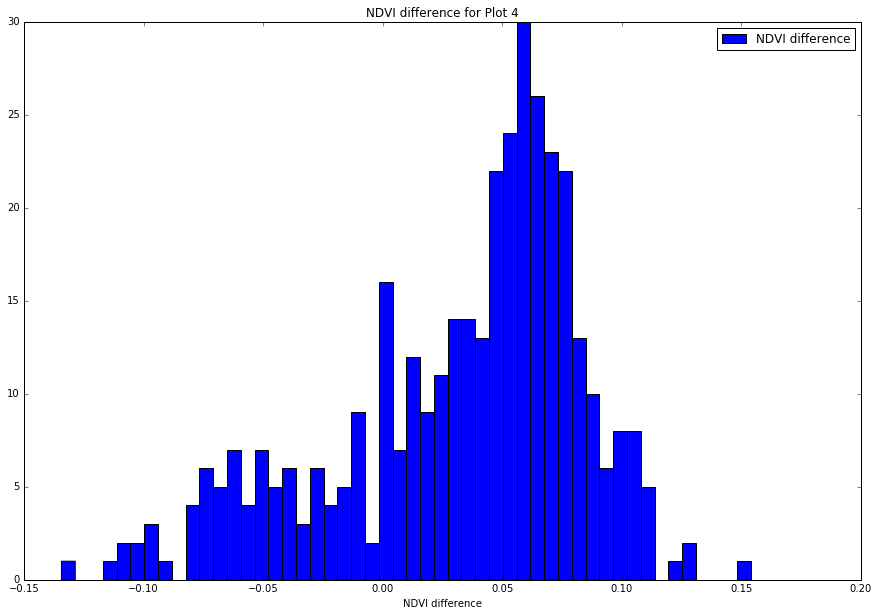

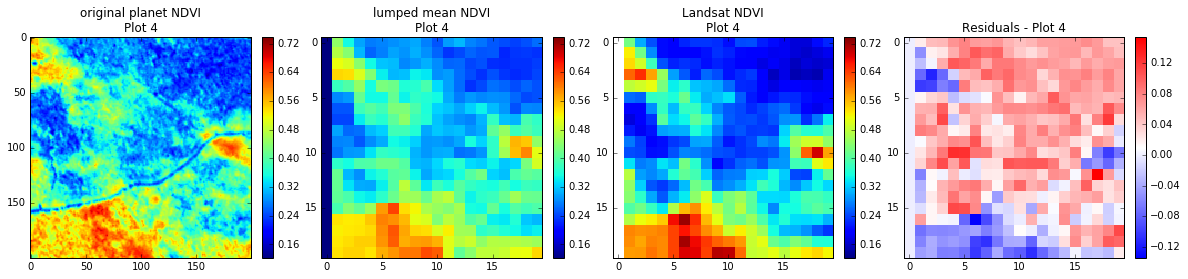

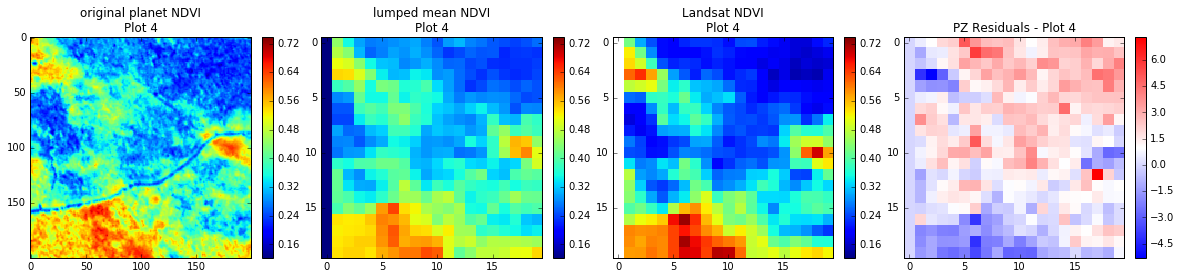

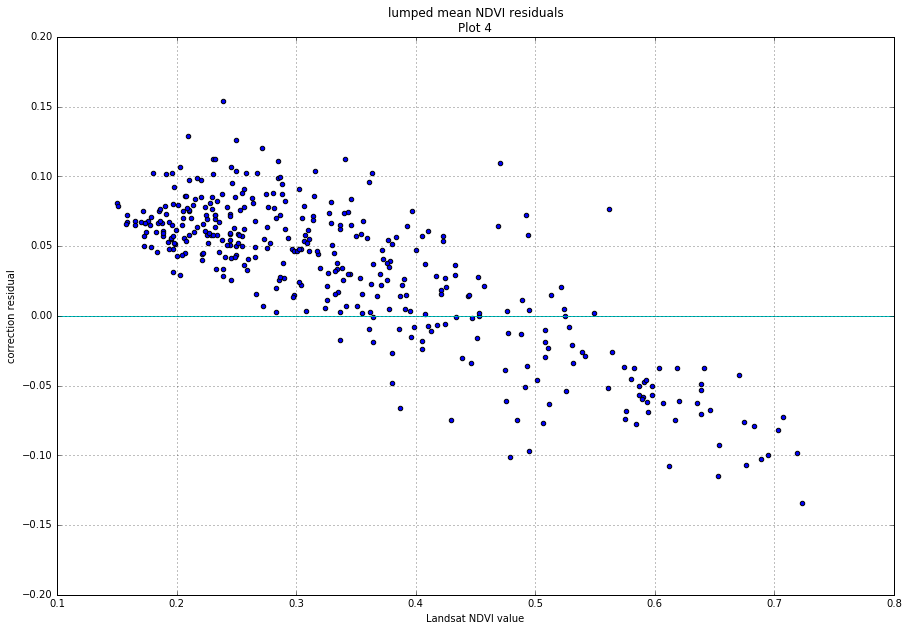

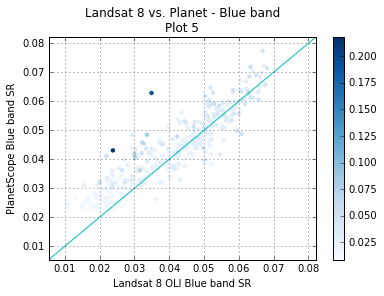

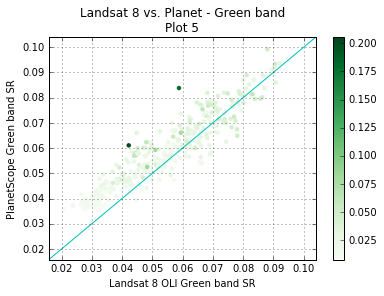

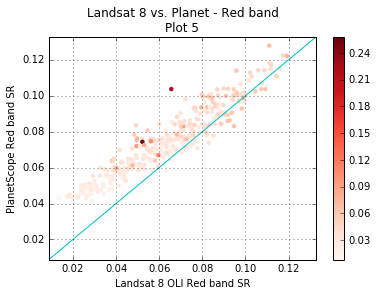

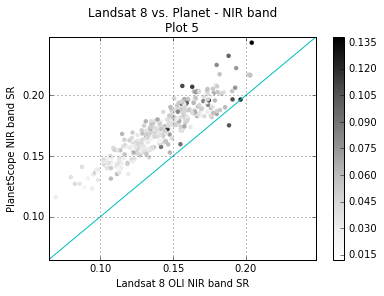

(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
using direct


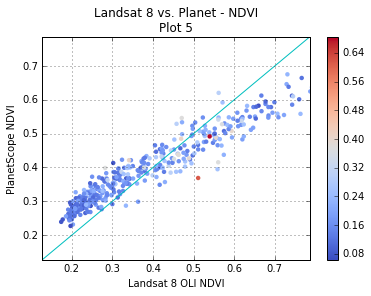

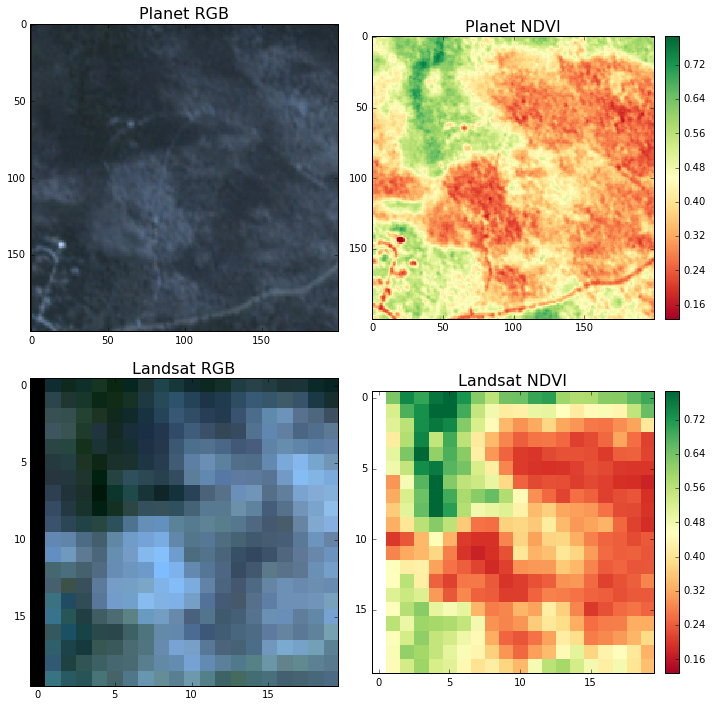

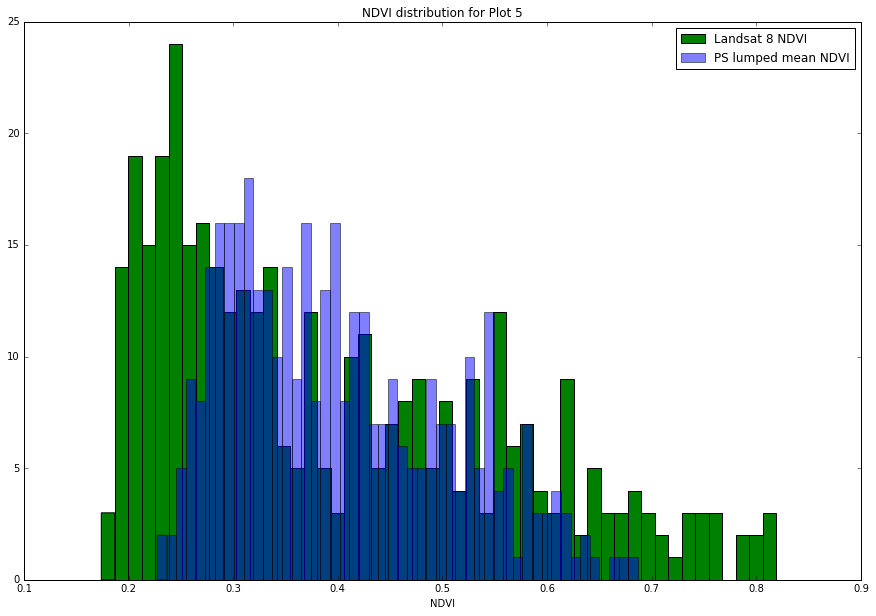

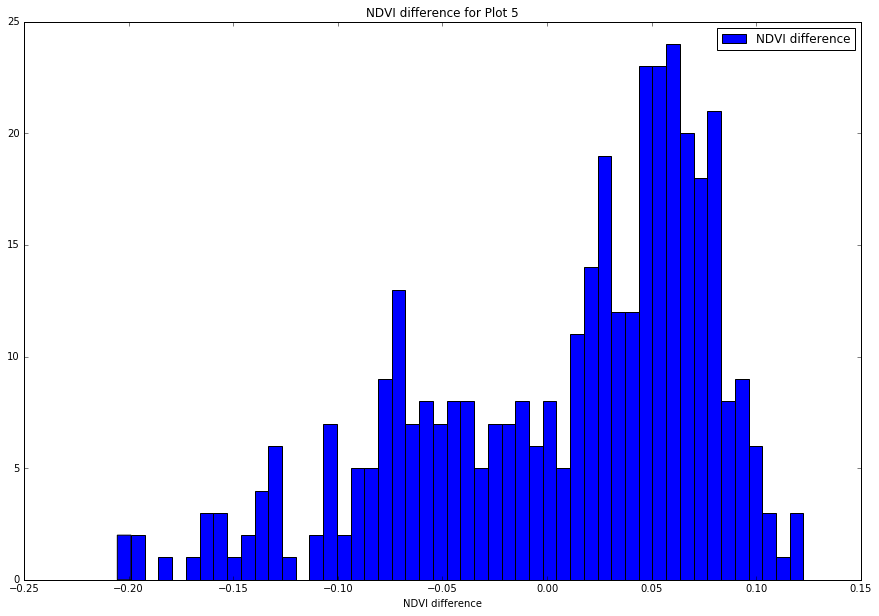

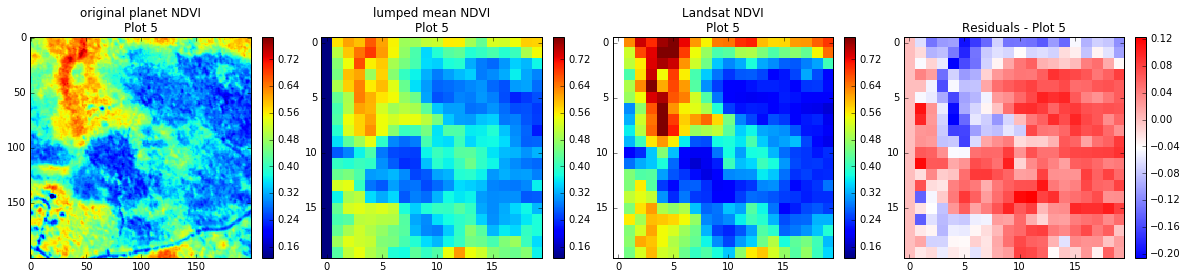

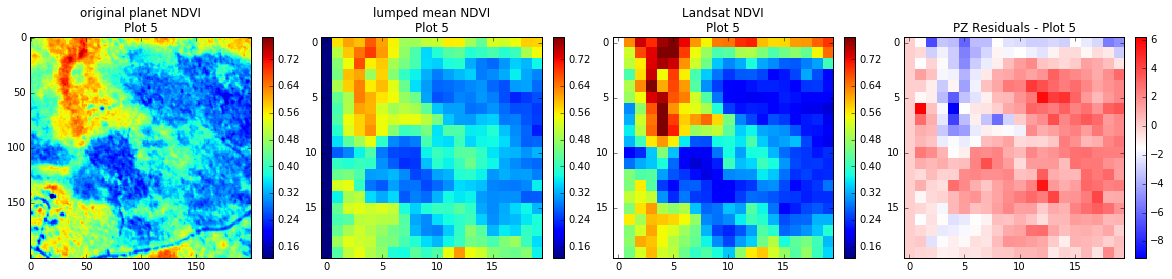

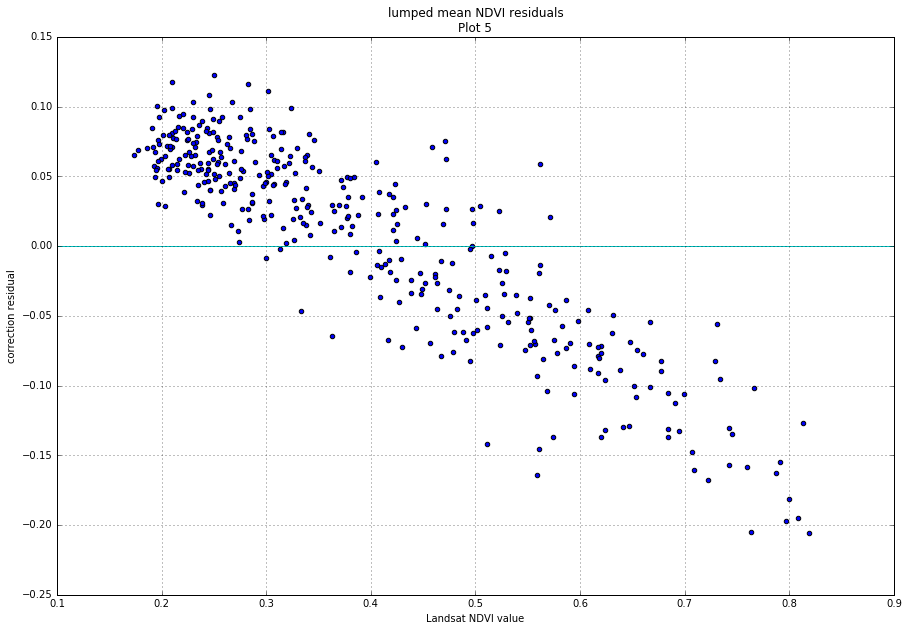

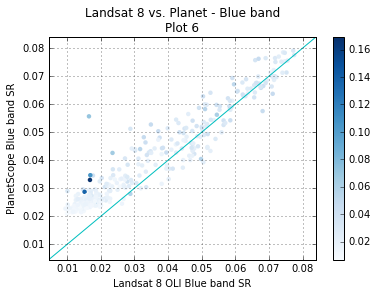

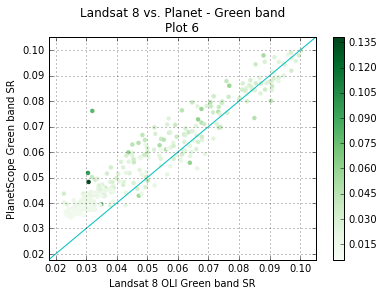

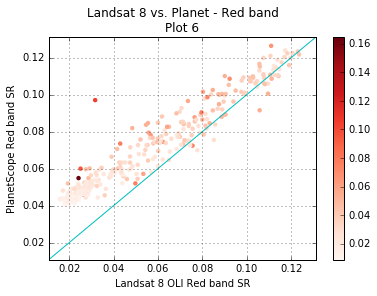

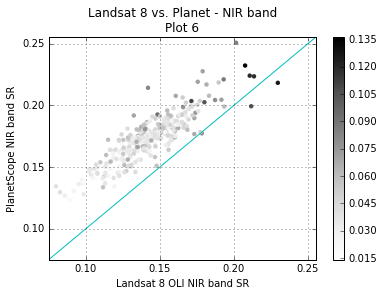

(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
using direct


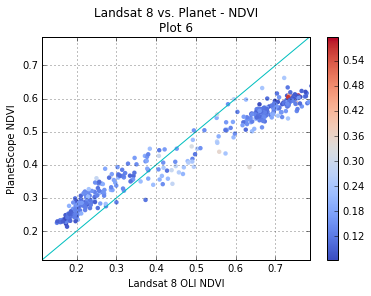

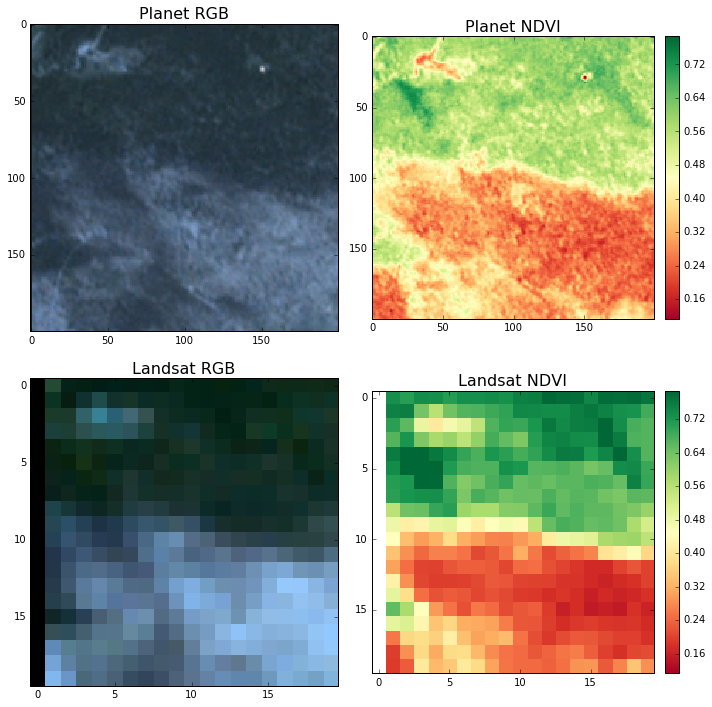

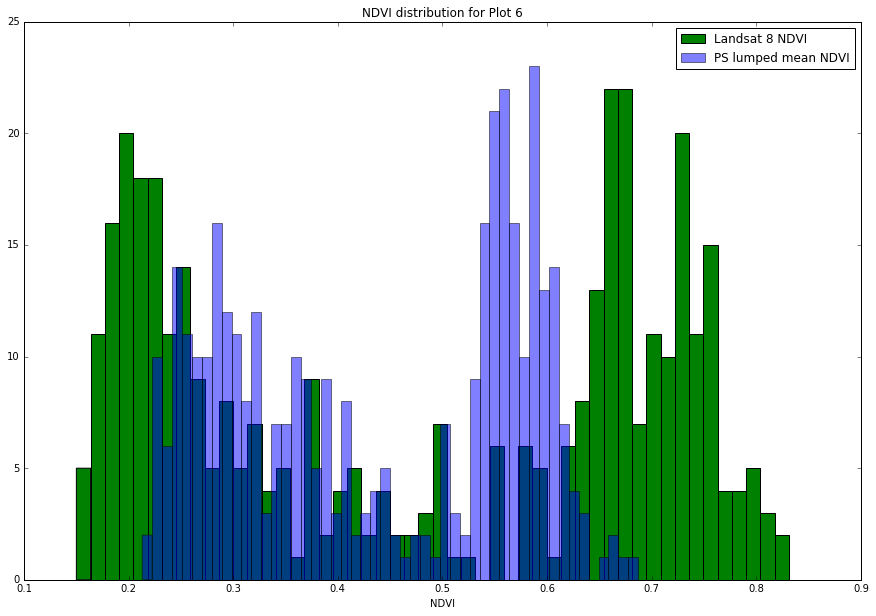

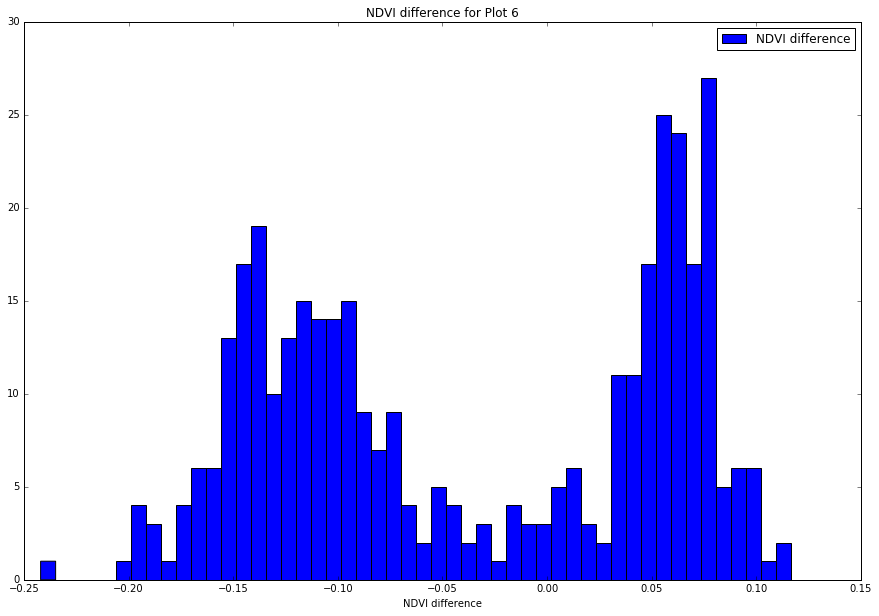

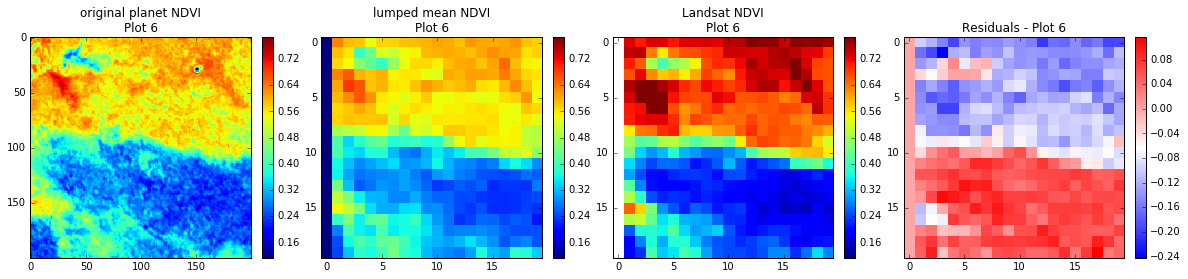

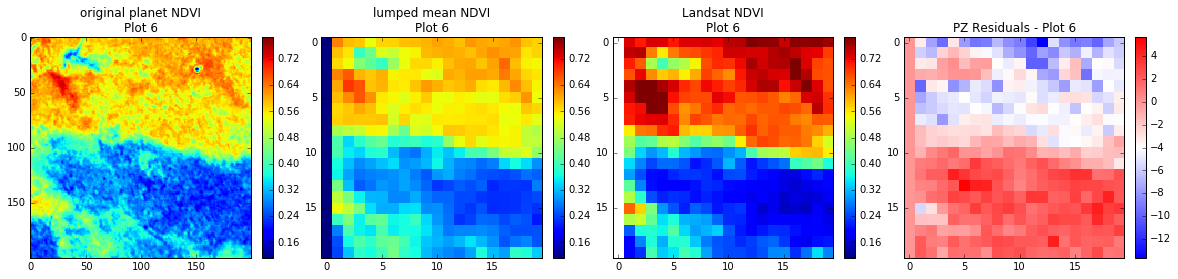

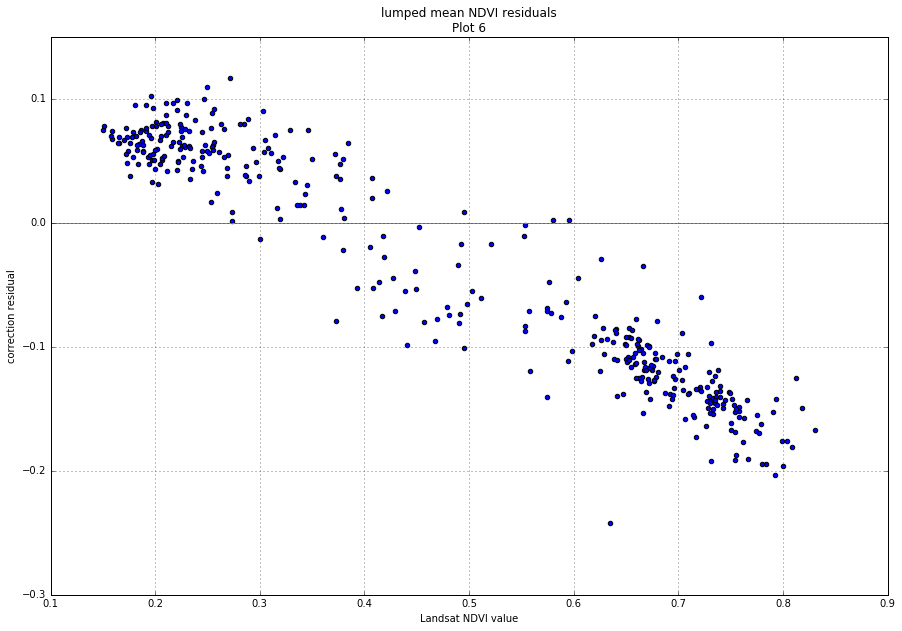

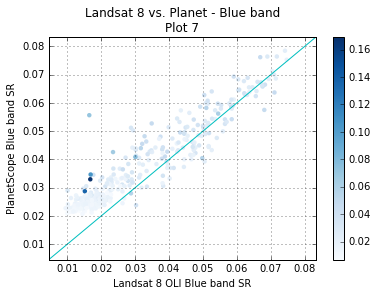

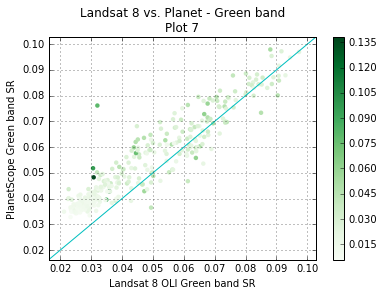

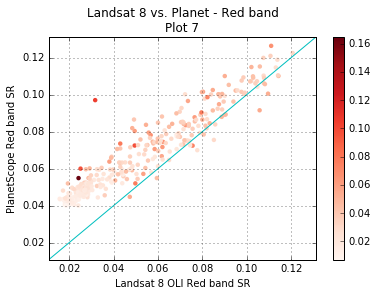

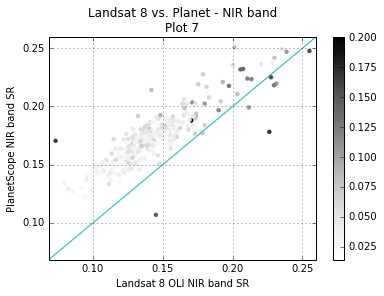

(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
(10, 0L, array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190], dtype=int64))
using direct


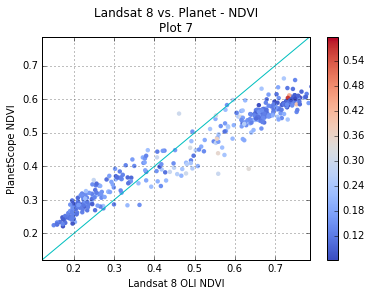

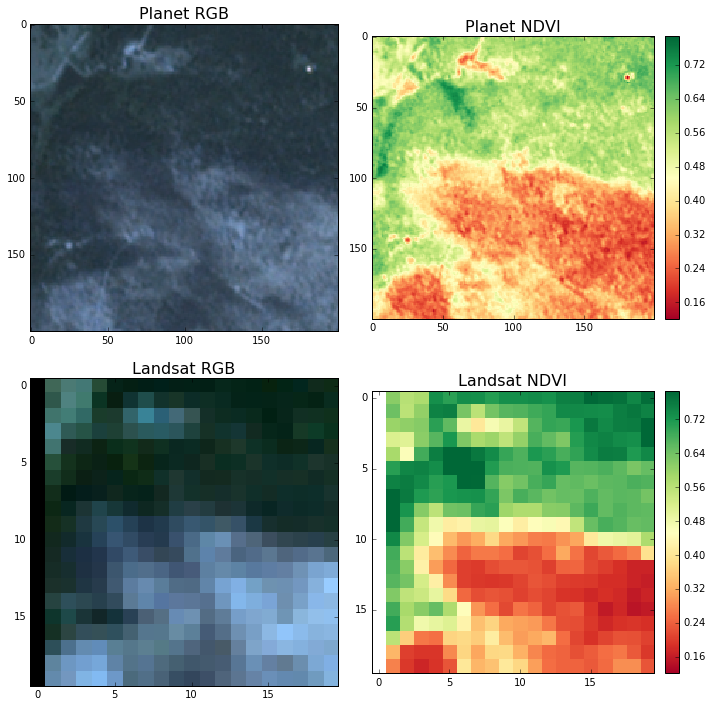

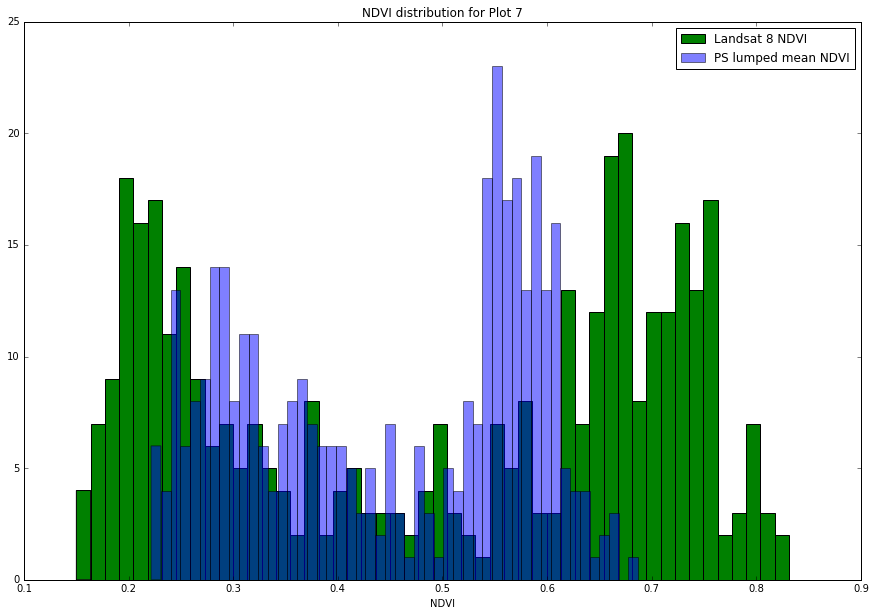

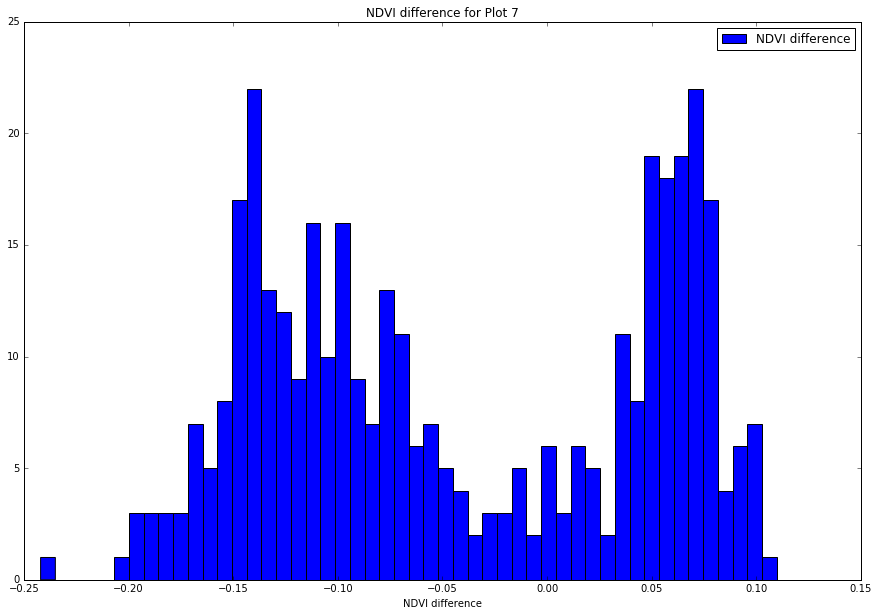

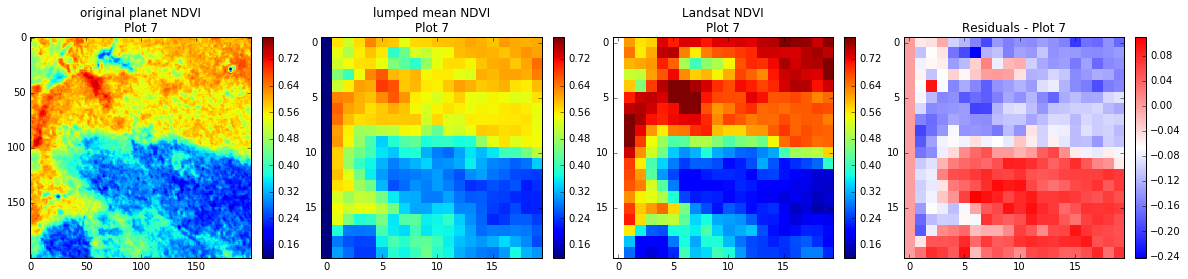

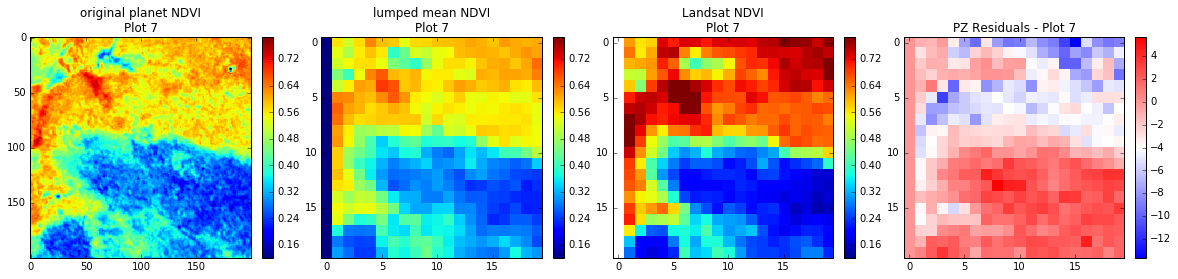

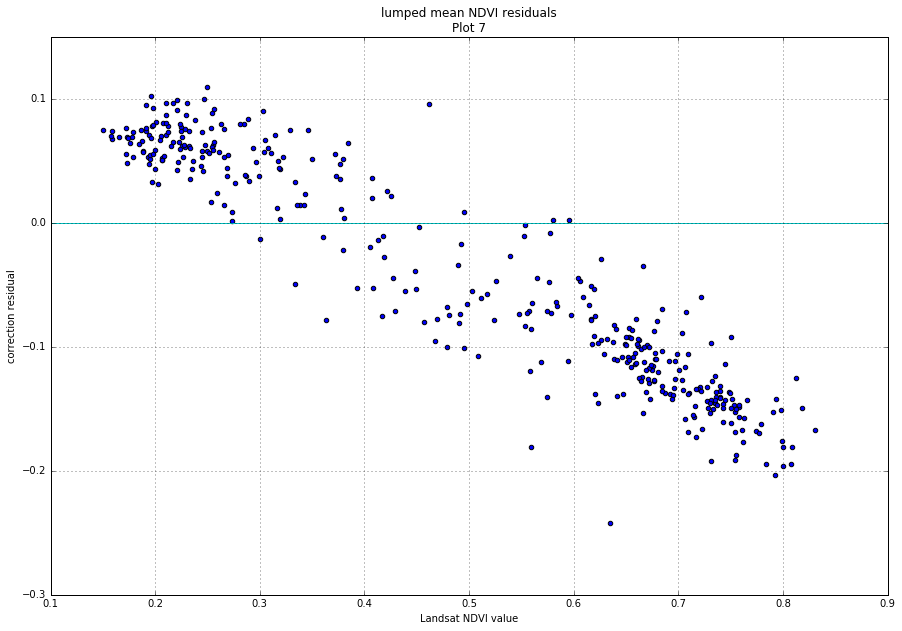

In [49]:
for plot_ind in range(7):
    blue_samples = returnSamplesMeanStd(planet[plot_ind]['image'][0,:,:], oli[plot_ind]['image'][0,:,:])
    green_samples = returnSamplesMeanStd(planet[plot_ind]['image'][1,:,:], oli[plot_ind]['image'][1,:,:])
    red_samples = returnSamplesMeanStd(planet[plot_ind]['image'][2,:,:], oli[plot_ind]['image'][2,:,:])
    nir_samples = returnSamplesMeanStd(planet[plot_ind]['image'][3,:,:], oli[plot_ind]['image'][3,:,:])

    max_refl = np.max(np.array((blue_samples, green_samples, red_samples, nir_samples)))
    min_refl = np.min(np.array((blue_samples, green_samples, red_samples, nir_samples)))

    ## make some band plots

    colors = ['b', 'g', 'r', 'k']
    colors = ['Blues', 'Greens', 'Reds', 'Greys']
    bands = ['Blue', 'Green', 'Red', 'NIR']
    samps = [blue_samples, green_samples, red_samples, nir_samples]
    for i, pack in enumerate(zip(samps, bands)):

        data, band = pack

        # create a new figure and get the axes
        fig = plt.figure()
        ax = plt.gca()
        ax.set_autoscale_on(False)


        # concatenate the samples
        test = np.hstack(data)
        max_refl = np.max(np.array(test[:2,:]))
        min_refl = np.min(np.array(test[:2,:]))

        # set some axis limits
        refl_ext = 0.005
        plt.ylim(min_refl - refl_ext, max_refl + refl_ext)
        plt.xlim(min_refl - refl_ext, max_refl + refl_ext)
        
        # other scatter plot
        plt.scatter(test[0,:], test[1,:], alpha=0.99, c=test[3,:], edgecolor='none', cmap=colors[i]) # colored by range

        # get some numbers for a 1:1 line
        minx, maxx, miny, maxy = 0.0, max_refl + refl_ext, 0.0, max_refl + refl_ext
        extend = 0.01
        l = mlines.Line2D([minx, maxx], [miny, maxy], color='c')
        ax.add_line(l)

        plt.grid()
        plt.colorbar()

        plt.title('Landsat 8 vs. Planet - {} band\nPlot {}'.format(band, plot_ind+1))
        plt.xlabel('Landsat 8 OLI {} band SR'.format(band))
        plt.ylabel('PlanetScope {} band SR'.format(band))
        plt.show()

        fig_name = 'plot_{}_{}_band_coloredRANGE_niwot_scatter.png'.format(plot_ind+1, band)
        fig_name = os.path.join(ndvi_figs, fig_name)
        fig.savefig(fig_name)

        plt.clf()

    # use the function instead
    ndvi_ls = returnSamplesMeanStd_ndvi(planet[plot_ind]['image'][2,:,:], 
                                     planet[plot_ind]['image'][3,:,:],
                                     oli[plot_ind]['image'][2,:,:], 
                                     oli[plot_ind]['image'][3,:,:],
                                     method='direct')
    
    ndvi = np.hstack(ndvi_ls)
    oli_ndvi = ndvi[0,:]
    pl_ndvi = ndvi[1,:]

    # create a new figure and get the axes
    fig = plt.figure()
    ax = plt.gca()
    ax.set_autoscale_on(False)

    # set some axis limits
    ndvi_ext = 0.1
    min_ndvi = np.min(pl_ndvi) #0.1
    max_ndvi = np.max(pl_ndvi) #0.5
    plt.ylim(min_ndvi - ndvi_ext, max_ndvi + ndvi_ext)
    plt.xlim(min_ndvi - ndvi_ext, max_ndvi + ndvi_ext)

    # other scatter plot
    sc = ax.scatter(oli_ndvi, pl_ndvi, alpha=0.99, c=ndvi[3,:], edgecolor='none', cmap='coolwarm') # colored by range
    plt.colorbar(sc)

    # get some numbers for a 1:1 line
    minx, maxx, miny, maxy = min_ndvi - ndvi_ext, max_ndvi + ndvi_ext, min_ndvi - ndvi_ext, max_ndvi + ndvi_ext
    extend = 0.01
    l = mlines.Line2D([minx - extend, maxx + extend], [miny - extend, maxy + extend], color='c')
    ax.add_line(l)

    plt.grid()

    plt.title('Landsat 8 vs. Planet - NDVI\nPlot {}'.format(plot_ind+1))
    plt.xlabel('Landsat 8 OLI NDVI')
    plt.ylabel('PlanetScope NDVI')
    plt.show()
    
    fig_name = 'plot_{}_coloredRANGE_niwot_NDVI_scatter.png'.format(plot_ind+1)
    fig_name = os.path.join(ndvi_figs, fig_name)
    fig.savefig(fig_name)

    plt.clf()


    fsize=(10,10)
    f, axes = plt.subplots(2, 2, figsize=fsize)
    # set up a dictionary for the title
    font_dict = {'fontsize': 16}

    # calculate NDVI real quick
    pl_im = np.rollaxis(planet[plot_ind]['image'][:3], 0,3)
    pl_ndvi_num = planet[plot_ind]['image'][3] - planet[plot_ind]['image'][2]
    pl_ndvi_den = planet[plot_ind]['image'][3] + planet[plot_ind]['image'][2]
    pl_ndvi_im = pl_ndvi_num / pl_ndvi_den

    oli_im = np.rollaxis(oli[plot_ind]['image'][:3], 0, 3)
    oli_ndvi_num = oli[plot_ind]['image'][3] - oli[plot_ind]['image'][2]
    oli_ndvi_den = oli[plot_ind]['image'][3] + oli[plot_ind]['image'][2]
    oli_ndvi_im = oli_ndvi_num / oli_ndvi_den

    axes[0,0].imshow(misc.bytescale(pl_im), interpolation='nearest', alpha = 0.9)
    axes[0,0].set_title('Planet RGB', fontdict = font_dict)
    cf = axes[0,1].imshow(pl_ndvi_im, interpolation='nearest', cmap='RdYlGn', vmin=min_ndvi-.1, vmax=max_ndvi+.1)
    colorbar(cf)
    axes[0,1].set_title('Planet NDVI', fontdict = font_dict)

    axes[1,0].imshow(misc.bytescale(oli_im), interpolation='nearest')
    axes[1,0].set_title('Landsat RGB', fontdict = font_dict)
    cf = axes[1,1].imshow(oli_ndvi_im, interpolation='nearest',cmap='RdYlGn', vmin=min_ndvi-.1, vmax=max_ndvi+.1)
    colorbar(cf)
    axes[1,1].set_title('Landsat NDVI', fontdict = font_dict)

    f.tight_layout()
    
    fig_name = 'plot_{}_niwot_planet_oli_ndvi_source_res.png'.format(plot_ind+1)
    fig_name = os.path.join(ndvi_figs, fig_name)
    f.savefig(fig_name)

    # now the ndvi aggregation plots
    ndvi = np.array(ndvi_ls).squeeze()

    
    # histogram plots
    fig=plt.figure(figsize=(15,10))
    plt.hist(ndvi[:,0], bins=50, label='Landsat 8 NDVI', color='g')
    plt.hist(ndvi[:,1], bins=50, alpha=0.5, label='PS lumped mean NDVI')
    plt.legend()
    plt.xlabel('NDVI')
    plt.title('NDVI distribution for Plot {}'.format(plot_ind+1))
    plt.show()
    
    # save it
    fig_name = 'plot_{}_niwot_NDVI_histogram_planet_landsat.png'.format(plot_ind+1)
    fig_name = os.path.join(ndvi_figs, fig_name)
    fig.savefig(fig_name)
    
    fig=plt.figure(figsize=(15,10))
    plt.hist(ndvi[:,1] - ndvi[:,0], bins=50, label='NDVI difference')
    plt.title('NDVI difference for Plot {}'.format(plot_ind+1))
    plt.legend()
    plt.xlabel('NDVI difference')
    plt.show()
    
    # save it
    fig_name = 'plot_{}_niwot_NDVI_histogramDIF_planet_landsat.png'.format(plot_ind+1)
    fig_name = os.path.join(ndvi_figs, fig_name)
    fig.savefig(fig_name)
    
    # images
    ndvi_im = np.zeros(oli_ndvi_im.shape)
    ndvi_im[oli_ndvi_im != np.ma.masked] = ndvi[:,1]
    ndvi_resid_im = np.zeros(oli_ndvi_im.shape)
    ndvi_resid_im[oli_ndvi_im != np.ma.masked] = ndvi[:,1] - ndvi[:,0]

    fig=plt.figure(figsize=(20,10))
    plt.subplot(141)
    cf = plt.imshow(pl_ndvi_im, interpolation='nearest', vmin=min_ndvi-.1, vmax=max_ndvi+.1)
    plt.title('original planet NDVI\nPlot {}'.format(plot_ind+1))
    colorbar(cf)
    plt.subplot(142)
    cf = plt.imshow(ndvi_im, interpolation='nearest', vmin=min_ndvi-.1, vmax=max_ndvi+.1)
    plt.title('lumped mean NDVI\nPlot {}'.format(plot_ind+1))
    colorbar(cf)
    plt.subplot(143)
    cf = plt.imshow(oli_ndvi_im, interpolation='nearest', vmin=min_ndvi-.1, vmax=max_ndvi+.1)
    plt.title('Landsat NDVI\nPlot {}'.format(plot_ind+1))
    colorbar(cf)
    plt.subplot(144)
    cf = plt.imshow(ndvi_resid_im, interpolation='nearest', cmap='bwr')
    plt.title('Residuals - Plot {}'.format(plot_ind+1))
    colorbar(cf)
    plt.show()
    
    # save it
    fig_name = 'plot_{}_niwot_lumpedMean_NDVI_image_planet_landsat_resids.png'.format(plot_ind+1)
    fig_name = os.path.join(ndvi_figs, fig_name)
    fig.savefig(fig_name)
    
    ## take a look at a pseudo z score
    pz = (ndvi[:,1] - ndvi[:,0]) / ndvi[:,2]
    pz_im = np.zeros(oli_ndvi_im.shape)
    pz_im[oli_ndvi_im != np.ma.masked] = pz

    fig=plt.figure(figsize=(20,10))
    plt.subplot(141)
    cf = plt.imshow(pl_ndvi_im, interpolation='nearest', vmin=min_ndvi-.1, vmax=max_ndvi+.1)
    plt.title('original planet NDVI\nPlot {}'.format(plot_ind+1))
    colorbar(cf)
    plt.subplot(142)
    cf = plt.imshow(ndvi_im, interpolation='nearest', vmin=min_ndvi-.1, vmax=max_ndvi+.1)
    plt.title('lumped mean NDVI\nPlot {}'.format(plot_ind+1))
    colorbar(cf)
    plt.subplot(143)
    cf = plt.imshow(oli_ndvi_im, interpolation='nearest', vmin=min_ndvi-.1, vmax=max_ndvi+.1)
    plt.title('Landsat NDVI\nPlot {}'.format(plot_ind+1))
    colorbar(cf)
    plt.subplot(144)
    cf = plt.imshow(pz_im, interpolation='nearest', cmap='bwr')
    plt.title('PZ Residuals - Plot {}'.format(plot_ind+1))
    colorbar(cf)
    plt.show()
    
    # save it
    fig_name = 'plot_{}_niwot_lumpedMean_NDVI_image_planet_landsat_PZresids.png'.format(plot_ind+1)
    fig_name = os.path.join(ndvi_figs, fig_name)
    fig.savefig(fig_name)
    
    # plot the residuals
    fig=plt.figure(figsize=(15,10))
    plt.scatter(ndvi[:,0], ndvi[:,1] - ndvi[:,0])
    plt.title('lumped mean NDVI residuals\nPlot {}'.format(plot_ind+1))
    plt.xlabel('Landsat NDVI value')
    plt.ylabel('correction residual')

    # get some numbers for a 1:1 line
    minx, maxx, miny, maxy = oli_ndvi_im.min()-ndvi_ext, oli_ndvi_im.max() + ndvi_ext, 0., 0.
    extend = 0.01
    l = mlines.Line2D([minx - extend, maxx + extend], [miny, maxy], color='c')
    plt.gca().add_line(l)

    plt.grid()

    plt.show()
    
    # save it
    fig_name = 'plot_{}_niwot_lumpedMean_NDVI_scatter_resids.png'.format(plot_ind+1)
    fig_name = os.path.join(ndvi_figs, fig_name)
    fig.savefig(fig_name)